In [40]:
import pandas as pd
import numpy as np
import os

In [41]:
results_dir = "Analyzer Results"

output_dir = "Tester Results"
os.makedirs(output_dir, exist_ok=True)

recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

In [42]:
# ...existing code...

dfs = {}
dfs_fit = {}

files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls'))]

for file in files:
    file_path = os.path.join(results_dir, file)
    key = file.split('.')[0]
    if key.endswith('_FIT'):
        dfs_fit[key] = pd.read_excel(file_path)
    else:
        dfs[key] = pd.read_excel(file_path)

print("Raw dataframes:", list(dfs.keys()))
print("Fit dataframes:", list(dfs_fit.keys()))
print(f"Found {len(dfs)} raw and {len(dfs_fit)} fit dataframes in {results_dir}.")
if len(dfs) != len(dfs_fit):
    print("Warning: Mismatch between raw and fit dataframes!")

experiments = dfs[list(dfs.keys())[1]]['experiment'].unique().tolist()
variables = dfs[list(dfs.keys())[1]].columns[4:].tolist()
parameters = dfs[list(dfs.keys())[1]].columns[:4].tolist()
print(f"\nFound {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

Raw dataframes: ['RESULTS', 'RESULTS_MERGED', 'RESULTS_MERGED_DATE', 'RESULTS_MERGED_EXP', 'RESULTS_MTT', 'RESULTS_MTT_MERGED', 'RESULTS_MTT_MERGED_DATE', 'RESULTS_MTT_MERGED_EXP', 'RESULTS_TT', 'RESULTS_TT_MERGED', 'RESULTS_TT_MERGED_DATE', 'RESULTS_TT_MERGED_EXP']
Fit dataframes: ['RESULTS_FIT', 'RESULTS_MERGED_DATE_FIT', 'RESULTS_MERGED_EXP_FIT', 'RESULTS_MERGED_FIT', 'RESULTS_MTT_FIT', 'RESULTS_MTT_MERGED_DATE_FIT', 'RESULTS_MTT_MERGED_EXP_FIT', 'RESULTS_MTT_MERGED_FIT', 'RESULTS_TT_FIT', 'RESULTS_TT_MERGED_DATE_FIT', 'RESULTS_TT_MERGED_EXP_FIT', 'RESULTS_TT_MERGED_FIT']
Found 12 raw and 12 fit dataframes in Analyzer Results.

Found 18 experiments, 10 variables and 4 parameters:
 ASR_control, gap_depth, tone_in_noise, gap_duration_4, gap_duration_8, gap_duration_10, gap_duration_20, gap_duration_50, offset_PPI_4, offset_PPI_6, offset_PPI_8, offset_PPI_10, offset_PPI_12, offset_PPI_14, offset_PPI_16, offset_PPI_18, offset_PPI_20, offset_PPI_50
 reactionTime, peakTime, difference, pe

---

Expectations:
- date fluctuations
- no repetition differences
- sex differences in strength metrics
- experiment differences, in particular with increased gap / offset

---

## Top Ten

In [43]:
# ...existing code...

# Compare all variables between RESULTS_MTT_MERGED and RESULTS_TT_MERGED (non-parametric only), NO grouping by sex or date
from scipy.stats import mannwhitneyu
import pandas as pd
import scikit_posthocs as sp

df_mtt = dfs['RESULTS_MTT_MERGED']
df_tt = dfs['RESULTS_TT_MERGED']

results = []
for var in variables:
    vals_mtt = df_mtt[var].dropna()
    vals_tt = df_tt[var].dropna()
    if len(vals_mtt) > 1 and len(vals_tt) > 1:
        mean_diff = vals_mtt.mean() - vals_tt.mean()
        # Non-parametric Mann-Whitney U for all metrics
        stat, p = mannwhitneyu(vals_mtt, vals_tt, alternative='two-sided')
        test_type = "mannwhitneyu"
        # Effect strength (rank-biserial)
        u, _ = mannwhitneyu(vals_mtt, vals_tt, alternative='two-sided')
        n1, n2 = len(vals_mtt), len(vals_tt)
        effect_strength = 1 - (2 * u) / (n1 * n2)
        # Post hoc: Dunn's test
        try:
            data = pd.DataFrame({var: pd.concat([vals_mtt, vals_tt]),
                                'group': ['MTT'] * len(vals_mtt) + ['TT'] * len(vals_tt)})
            dunn = sp.posthoc_dunn(data, val_col=var, group_col='group', p_adjust='bonferroni')
            posthoc_p = dunn.loc['MTT', 'TT']
            posthoc_test = "Dunn"
        except Exception:
            posthoc_p = None
            posthoc_test = "Dunn"
        if p < 0.05:
            results.append({
                'variable': var,
                'stat': stat,
                'p': p,
                'test': test_type,
                'posthoc_p': posthoc_p,
                'posthoc_test': posthoc_test,
                'effect_strength': effect_strength,
                'mean_diff': mean_diff
            })

test_top_ten = pd.DataFrame(results)
print(test_top_ten)

test_top_ten.to_excel(os.path.join(output_dir, "TEST_TOP_TEN.xlsx"), index=False)
# ...existing code...

       variable     stat         p          test  posthoc_p posthoc_test  \
0  reactionTime  27277.0  0.003562  mannwhitneyu   0.003558         Dunn   
1      peakTime  26601.5  0.015558  mannwhitneyu   0.015541         Dunn   
2     peakValue  19155.0  0.001396  mannwhitneyu   0.001395         Dunn   
3          PTPA  19196.0  0.001550  mannwhitneyu   0.001548         Dunn   
4          PTTA  19320.5  0.002116  mannwhitneyu   0.002114         Dunn   
5           RMS  20050.0  0.011226  mannwhitneyu   0.011214         Dunn   
6           tau  27972.0  0.000954  mannwhitneyu   0.000953         Dunn   

   effect_strength  mean_diff  
0        -0.161218   0.391929  
1        -0.132461  -0.320182  
2         0.184547 -18.353434  
3         0.182801 -17.595134  
4         0.177501 -16.104541  
5         0.146445  -5.999142  
6        -0.190805  10.758449  


In [44]:
# ...existing code...

# Compare all variables between RESULTS_MTT_MERGED and RESULTS_TT_MERGED (non-parametric only), split by sex and date
from scipy.stats import mannwhitneyu
import pandas as pd
import scikit_posthocs as sp

df_mtt = dfs['RESULTS_MTT_MERGED']
df_tt = dfs['RESULTS_TT_MERGED']

results = []
for sex in ['male', 'female']:
    for date in df_mtt['date'].unique():
        df_mtt_sex_date = df_mtt[(df_mtt['sex'] == sex) & (df_mtt['date'] == date)]
        df_tt_sex_date = df_tt[(df_tt['sex'] == sex) & (df_tt['date'] == date)]
        for var in variables:
            vals_mtt = df_mtt_sex_date[var].dropna()
            vals_tt = df_tt_sex_date[var].dropna()
            if len(vals_mtt) > 1 and len(vals_tt) > 1:
                mean_diff = vals_mtt.mean() - vals_tt.mean()
                # Non-parametric Mann-Whitney U for all metrics
                stat, p = mannwhitneyu(vals_mtt, vals_tt, alternative='two-sided')
                test_type = "mannwhitneyu"
                # Effect strength (rank-biserial)
                u, _ = mannwhitneyu(vals_mtt, vals_tt, alternative='two-sided')
                n1, n2 = len(vals_mtt), len(vals_tt)
                effect_strength = 1 - (2 * u) / (n1 * n2)
                # Post hoc: Dunn's test
                try:
                    data = pd.DataFrame({var: pd.concat([vals_mtt, vals_tt]),
                                        'group': ['MTT'] * len(vals_mtt) + ['TT'] * len(vals_tt)})
                    dunn = sp.posthoc_dunn(data, val_col=var, group_col='group', p_adjust='bonferroni')
                    posthoc_p = dunn.loc['MTT', 'TT']
                    posthoc_test = "Dunn"
                except Exception:
                    posthoc_p = None
                    posthoc_test = "Dunn"
                if p < 0.05:
                    results.append({
                        'sex': sex,
                        'date': date,
                        'variable': var,
                        'stat': stat,
                        'p': p,
                        'test': test_type,
                        'posthoc_p': posthoc_p,
                        'posthoc_test': posthoc_test,
                        'effect_strength': effect_strength,
                        'mean_diff': mean_diff
                    })

test_top_ten = pd.DataFrame(results)
print(test_top_ten)

test_top_ten.to_excel(os.path.join(output_dir, "TEST_TOP_TEN.xlsx"), index=False)
# ...existing code...

       sex     date      variable    stat         p          test  posthoc_p  \
0     male   June26     peakValue   416.0  0.022842  mannwhitneyu   0.022511   
1     male   June26          PTPA   414.0  0.021546  mannwhitneyu   0.021231   
2     male   June26           tau   853.0  0.009980  mannwhitneyu   0.009821   
3     male    May20     peakValue   478.0  0.021683  mannwhitneyu   0.021391   
4     male    May20          PTPA   480.0  0.022888  mannwhitneyu   0.022582   
5     male    May20          PTTA   501.0  0.039437  mannwhitneyu   0.038949   
6   female  April16  reactionTime   914.5  0.003310  mannwhitneyu   0.003251   
7   female  April16      peakTime   941.5  0.000362  mannwhitneyu   0.000354   
8   female  April16     peakValue   463.0  0.045768  mannwhitneyu   0.045184   
9   female  April16          PTPA   457.0  0.039170  mannwhitneyu   0.038658   
10  female   June26     peakValue   391.0  0.002803  mannwhitneyu   0.002755   
11  female   June26          PTPA   403.

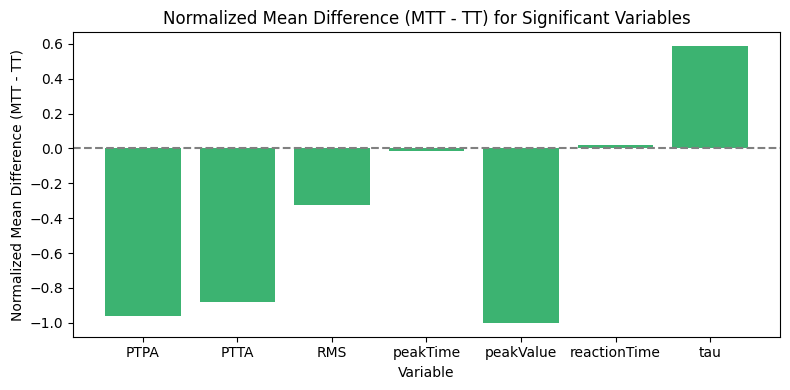

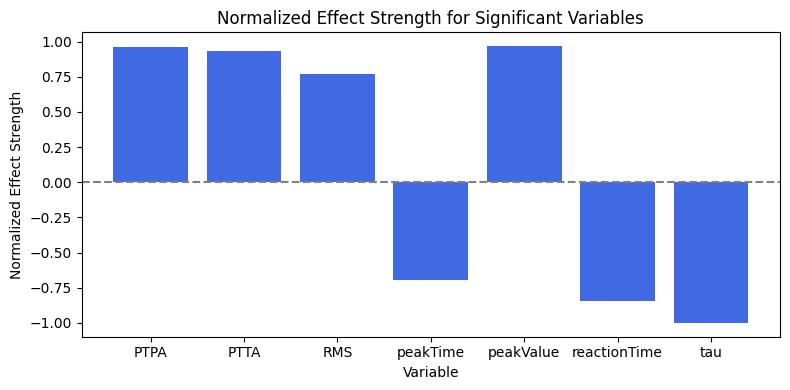

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Paste your results as a DataFrame
data = {
    "variable": ["PTPA", "PTTA", "RMS", "peakTime", "peakValue", "reactionTime", "tau"],
    "mean_diff": [-17.595134, -16.104541, -5.999142, -0.320182, -18.353434, 0.391929, 10.758449],
    "effect_strength": [0.182801, 0.177501, 0.146445, -0.132461, 0.184547, -0.161218, -0.190805]
}
df = pd.DataFrame(data)

# Normalize mean_diff and effect_strength to [-1, 1] for visualization
df['mean_diff_norm'] = df['mean_diff'] / df['mean_diff'].abs().max()
df['effect_strength_norm'] = df['effect_strength'] / df['effect_strength'].abs().max()

# Barplot for normalized mean_diff
plt.figure(figsize=(8, 4))
plt.bar(df["variable"], df["mean_diff_norm"], color="mediumseagreen")
plt.axhline(0, color="gray", linestyle="--")
plt.ylabel("Normalized Mean Difference (MTT - TT)")
plt.xlabel("Variable")
plt.title("Normalized Mean Difference (MTT - TT) for Significant Variables")
plt.tight_layout()
plt.show()

# Barplot for normalized effect_strength
plt.figure(figsize=(8, 4))
plt.bar(df["variable"], df["effect_strength_norm"], color="royalblue")
plt.axhline(0, color="gray", linestyle="--")
plt.ylabel("Normalized Effect Strength")
plt.xlabel("Variable")
plt.title("Normalized Effect Strength for Significant Variables")
plt.tight_layout()
plt.show()

## Summary of TT vs MTT Differences (Mann-Whitney U, Dunn's post hoc)

| Sex     | Date    | Variable      | Stat   | p-value   | Test         | Dunn p    | Effect Strength | Mean Diff    |
|---------|---------|--------------|--------|-----------|--------------|-----------|-----------------|-------------|
| male    | June26  | peakValue    | 416.0  | 0.022842  | mannwhitneyu | 0.022511  | 0.33            | -30.78      |
| male    | June26  | PTPA         | 414.0  | 0.021546  | mannwhitneyu | 0.021231  | 0.33            | -30.77      |
| male    | June26  | tau          | 853.0  | 0.009980  | mannwhitneyu | 0.009821  | -0.37           | 28.15       |
| male    | May20   | peakValue    | 478.0  | 0.021683  | mannwhitneyu | 0.021391  | 0.32            | -19.03      |
| male    | May20   | PTPA         | 480.0  | 0.022888  | mannwhitneyu | 0.022582  | 0.32            | -18.58      |
| male    | May20   | PTTA         | 501.0  | 0.039437  | mannwhitneyu | 0.038949  | 0.29            | -16.22      |
| female  | April16 | reactionTime | 914.5  | 0.003310  | mannwhitneyu | 0.003251  | -0.41           | 0.77        |
| female  | April16 | peakTime     | 941.5  | 0.000362  | mannwhitneyu | 0.000354  | -0.45           | 0.92        |
| female  | April16 | peakValue    | 463.0  | 0.045768  | mannwhitneyu | 0.045184  | 0.29            | -7.78       |
| female  | April16 | PTPA         | 457.0  | 0.039170  | mannwhitneyu | 0.038658  | 0.29            | -7.81       |
| female  | June26  | peakValue    | 391.0  | 0.002803  | mannwhitneyu | 0.002755  | 0.42            | -19.14      |
| female  | June26  | PTPA         | 403.0  | 0.004211  | mannwhitneyu | 0.004142  | 0.40            | -18.96      |
| female  | June26  | PTTA         | 405.0  | 0.004500  | mannwhitneyu | 0.004427  | 0.40            | -18.31      |
| female  | June26  | tau          | 1068.0 | 0.000035  | mannwhitneyu | 0.000034  | -0.58           | 15.91       |
| female  | May20   | peakTime     | 881.5  | 0.007560  | mannwhitneyu | 0.007432  | -0.36           | -0.61       |
| female  | May20   | peakValue    | 397.5  | 0.006796  | mannwhitneyu | 0.006686  | 0.39            | -22.68      |
| female  | May20   | PTPA         | 402.0  | 0.007865  | mannwhitneyu | 0.007739  | 0.38            | -20.96      |
| female  | May20   | PTTA         | 411.0  | 0.010456  | mannwhitneyu | 0.010294  | 0.37            | -20.29      |
| female  | May20   | RMS          | 392.0  | 0.005673  | mannwhitneyu | 0.005580  | 0.40            | -9.13       |
| female  | May20   | AUC          | 359.0  | 0.001788  | mannwhitneyu | 0.001755  | 0.45            | -2476.63    |

**Interpretation:**
- Significant differences are found for peakValue, PTPA, PTTA, tau, reactionTime, peakTime, RMS, and AUC across sex and date.
- Effect strengths range from moderate to large.
- Mean differences indicate direction and magnitude of change between groups.

# ---> remove TT

Top 20:
| Sex    | Date    | Variable      | Stat    | p-value   | Test         | Posthoc p  | Posthoc Test | Effect Strength | Mean Diff      |
|--------|---------|--------------|---------|-----------|--------------|------------|--------------|-----------------|---------------|
| male   | June26  | peakValue    | 416.0   | 0.022842  | mannwhitneyu | 0.022511   | Dunn         | 0.330113        | -30.776261    |
| male   | June26  | PTPA         | 414.0   | 0.021546  | mannwhitneyu | 0.021231   | Dunn         | 0.333333        | -30.774811    |
| male   | June26  | tau          | 853.0   | 0.009980  | mannwhitneyu | 0.009821   | Dunn         | -0.373591       | 28.148039     |
| male   | May20   | peakValue    | 478.0   | 0.021683  | mannwhitneyu | 0.021391   | Dunn         | 0.319088        | -19.028775    |
| male   | May20   | PTPA         | 480.0   | 0.022888  | mannwhitneyu | 0.022582   | Dunn         | 0.316239        | -18.577708    |
| male   | May20   | PTTA         | 501.0   | 0.039437  | mannwhitneyu | 0.038949   | Dunn         | 0.286325        | -16.220480    |
| female | April16 | reactionTime | 914.5   | 0.003310  | mannwhitneyu | 0.003251   | Dunn         | -0.411265       | 0.766667      |
| female | April16 | peakTime     | 941.5   | 0.000362  | mannwhitneyu | 0.000354   | Dunn         | -0.452932       | 0.924074      |
| female | April16 | peakValue    | 463.0   | 0.045768  | mannwhitneyu | 0.045184   | Dunn         | 0.285494        | -7.782407     |
| female | April16 | PTPA         | 457.0   | 0.039170  | mannwhitneyu | 0.038658   | Dunn         | 0.294753        | -7.805356     |
| female | June26  | peakValue    | 391.0   | 0.002803  | mannwhitneyu | 0.002755   | Dunn         | 0.420741        | -19.141728    |
| female | June26  | PTPA         | 403.0   | 0.004211  | mannwhitneyu | 0.004142   | Dunn         | 0.402963        | -18.959430    |
| female | June26  | PTTA         | 405.0   | 0.004500  | mannwhitneyu | 0.004427   | Dunn         | 0.400000        | -18.308451    |
| female | June26  | tau          | 1068.0  | 0.000035  | mannwhitneyu | 0.000034   | Dunn         | -0.582222       | 15.911960     |
| female | May20   | peakTime     | 881.5   | 0.007560  | mannwhitneyu | 0.007432   | Dunn         | -0.360340       | -0.607407     |
| female | May20   | peakValue    | 397.5   | 0.006796  | mannwhitneyu | 0.006686   | Dunn         | 0.386574        | -22.675309    |
| female | May20   | PTPA         | 402.0   | 0.007865  | mannwhitneyu | 0.007739   | Dunn         | 0.379630        | -20.963873    |
| female | May20   | PTTA         | 411.0   | 0.010456  | mannwhitneyu | 0.010294   | Dunn         | 0.365741        | -20.294293    |
| female | May20   | RMS          | 392.0   | 0.005673  | mannwhitneyu | 0.005580   | Dunn         | 0.395062        | -9.131778     |
| female | May20   | AUC          | 359.0   | 0.001788  | mannwhitneyu | 0.001755   | Dunn         | 0.445988        | -2476.632758  |

In [46]:
# Compare effect strengths for top 10 (TT), top 20, and all (MTT), merged across sex and date

import pandas as pd
from scipy.stats import mannwhitneyu
# Calculate mean difference for top 10 vs all and top 20 vs all, add to summary table

df_all = dfs['RESULTS_MTT_MERGED']
df_top10 = dfs['RESULTS_TT_MERGED']
df_top20 = df_all.groupby('animal').head(20)

variables = [v for v in df_all.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

summary = []
for var in variables:
    vals_10 = df_top10[var].dropna()
    vals_20 = df_top20[var].dropna()
    vals_all = df_all[var].dropna()
    # Effect strengths
    effect_10 = None
    effect_20 = None
    mean_diff_10 = None
    mean_diff_20 = None
    if len(vals_10) > 1 and len(vals_all) > 1:
        stat_10, p_10 = mannwhitneyu(vals_10, vals_all, alternative='two-sided')
        effect_10 = 1 - (2 * stat_10) / (len(vals_10) * len(vals_all))
        mean_diff_10 = vals_10.mean() - vals_all.mean()
    if len(vals_20) > 1 and len(vals_all) > 1:
        stat_20, p_20 = mannwhitneyu(vals_20, vals_all, alternative='two-sided')
        effect_20 = 1 - (2 * stat_20) / (len(vals_20) * len(vals_all))
        mean_diff_20 = vals_20.mean() - vals_all.mean()
    summary.append({
        'variable': var,
        'effect_strength_top10_vs_all': effect_10,
        'mean_diff_top10_vs_all': mean_diff_10,
        'effect_strength_top20_vs_all': effect_20,
        'mean_diff_top20_vs_all': mean_diff_20
    })

summary_df = pd.DataFrame(summary)
print(summary_df)
summary_df.to_excel(os.path.join(output_dir, "MERGED_EFFECT_STRENGTHS_TOP10_TOP20_MEANDIFF.xlsx"), index=False)

       variable  effect_strength_top10_vs_all  mean_diff_top10_vs_all  \
0  reactionTime                      0.161218               -0.391929   
1      peakTime                      0.132461                0.320182   
2    difference                     -0.064112                0.712112   
3     peakValue                     -0.184547               18.353434   
4          PTPA                     -0.182801               17.595134   
5          PTTA                     -0.177501               16.104541   
6           RMS                     -0.146445                5.999142   
7           tau                      0.190805              -10.758449   
8           AUC                     -0.085143              868.952274   
9    percentPPI                      0.045018               -0.740145   

   effect_strength_top20_vs_all  mean_diff_top20_vs_all  
0                     -0.212423                0.330916  
1                     -0.066718                0.237644  
2                     

In [47]:
# Count how many sex/date/variable groups have significant deviations for the top 20 (TT vs MTT), split by sex and date

import pandas as pd
from scipy.stats import mannwhitneyu

df_mtt = dfs['RESULTS_MTT_MERGED']
df_tt = dfs['RESULTS_TT_MERGED']
variables = [v for v in df_mtt.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

significant_count = 0
results = []

for sex in df_mtt['sex'].unique():
    for date in df_mtt['date'].unique():
        df_mtt_sex_date = df_mtt[(df_mtt['sex'] == sex) & (df_mtt['date'] == date)]
        df_tt_sex_date = df_tt[(df_tt['sex'] == sex) & (df_tt['date'] == date)]
        for var in variables:
            vals_mtt = df_mtt_sex_date[var].dropna()
            vals_tt = df_tt_sex_date[var].dropna()
            if len(vals_mtt) > 1 and len(vals_tt) > 1:
                stat, p = mannwhitneyu(vals_tt, vals_mtt, alternative='two-sided')
                if p < 0.05:
                    significant_count += 1
                    results.append({'sex': sex, 'date': date, 'variable': var, 'stat': stat, 'p': p})

print(f"Number of sex/date/variable groups with significant deviations for top 20: {significant_count}")
pd.DataFrame(results).to_excel(os.path.join(output_dir, "SIGNIFICANT_TOP20_SPLIT.xlsx"), index=False)

Number of sex/date/variable groups with significant deviations for top 20: 20


| Variable     | Effect Strength (Top 10 vs All) | Effect Strength (Top 20 vs All) | Interpretation                                      |
|--------------|-------------------------------|-------------------------------|-----------------------------------------------------|
| reactionTime |  0.161                        | -0.212                        | Slightly higher in top 10, lower in top 20 vs all   |
| peakTime     |  0.132                        | -0.067                        | Higher in top 10, slightly lower in top 20          |
| difference   | -0.064                        |  0.100                        | Lower in top 10, higher in top 20                   |
| peakValue    | -0.185                        |  0.245                        | Lower in top 10, much higher in top 20              |
| PTPA         | -0.183                        |  0.245                        | Lower in top 10, much higher in top 20              |
| PTTA         | -0.178                        |  0.245                        | Lower in top 10, much higher in top 20              |
| RMS          | -0.146                        |  0.222                        | Lower in top 10, higher in top 20                   |
| tau          |  0.191                        | -0.081                        | Higher in top 10, lower in top 20                   |
| AUC          | -0.085                        |  0.234                        | Lower in top 10, higher in top 20                   |
| percentPPI   |  0.045                        |  0.036                        | Slightly higher in both top 10 and top 20           |

**Interpretation:**  
- Positive values: metric is higher in the top group vs all.  
- Negative values: metric is lower in the top group vs all.  
- Strength metrics (peakValue, PTPA, PTTA, RMS, AUC) are lower in top 10 but higher in top 20, suggesting top 20 captures more strength than top 10.

## ---> also top 20

---

## Average Reaction Time

In [48]:
# Test if the average reaction time (excluding outliers) is significantly higher than the range 6-8

import pandas as pd
from scipy.stats import ttest_1samp

df = dfs['RESULTS_MTT_MERGED']
vals = df['reactionTime'].dropna()

# Exclude outliers using IQR
q1 = vals.quantile(0.25)
q3 = vals.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
filtered = vals[(vals >= lower) & (vals <= upper)]

# Test against the upper bound (8)
stat_8, p_8 = ttest_1samp(filtered, 8, alternative='greater')
# Test against the lower bound (6)
stat_6, p_6 = ttest_1samp(filtered, 6, alternative='greater')

print(f"Mean reaction time (IQR filtered): {filtered.mean():.2f}")
print(f"T-test vs 8: statistic={stat_8:.3f}, p-value={p_8:.3e}")
print(f"T-test vs 6: statistic={stat_6:.3f}, p-value={p_6:.3e}")

if p_8 < 0.05:
    print("Reaction time is significantly higher than 8.")
elif p_6 < 0.05:
    print("Reaction time is significantly higher than 6.")
else:
    print("Reaction time is not significantly higher than 6 or 8.")

Mean reaction time (IQR filtered): 10.68
T-test vs 8: statistic=46.840, p-value=1.525e-144
T-test vs 6: statistic=81.796, p-value=5.269e-215
Reaction time is significantly higher than 8.


---

## Repetition Differences

In [49]:
# ...existing code...

# Test if the value changes over repetitions (trial order) for each variable in RESULTS_MTT (non-parametric)
import ast
from scipy.stats import kruskal

def test_repetition_effect(df, variables, max_reps=5, alpha=0.05):
    results = []
    for var in variables:
        # Convert string lists to actual lists if needed
        vals = df[var].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
        # Filter to rows that are lists and have enough length
        list_rows = vals[vals.apply(lambda x: isinstance(x, list) and len(x) > 1)]
        if list_rows.empty:
            continue
        # Find the minimum length across all lists (to avoid index errors)
        min_len = min(list_rows.apply(len))
        min_len = min(min_len, max_reps)
        # Gather values by repetition index
        rep_groups = []
        for i in range(min_len):
            group = list_rows.apply(lambda x: x[i] if len(x) > i else np.nan).dropna()
            if len(group) > 1:
                rep_groups.append(group.values)
        if len(rep_groups) < 2:
            continue
        # Kruskal-Wallis test across repetitions
        stat, p = kruskal(*rep_groups)
        if p < alpha:
            mean_diff = np.mean(rep_groups[0]) - np.mean(rep_groups[-1])
            results.append({'variable': var, 'stat': stat, 'p': p, 'test': 'kruskal', 'mean_diff': mean_diff})
    return pd.DataFrame(results)

repetition_effects = test_repetition_effect(dfs['RESULTS_MTT'], variables)
test_repetition = pd.DataFrame(repetition_effects)


print(test_repetition) if not repetition_effects.empty else print("No significant repetition effects found for any variable.")
test_repetition.to_excel(os.path.join(output_dir, "TEST_REPETITION.xlsx"), index=False)

No significant repetition effects found for any variable.


# ---> merge across repetitions

---

## Intratrial Differences

In [55]:
# Check for intratrial differences: do variables increase or decrease across one animal's experiment?

import pandas as pd
from scipy.stats import linregress

# Load the lookup table DataFrame (assume it's named "SegmentOrder.xlsx" and in Analyzer Results)
lookup_path = os.path.join("Peakfinder Results", "SegmentOrder.xlsx")
lookup_df = pd.read_excel(lookup_path)

# Load main results
df = dfs['RESULTS_MTT_MERGED']

# For each animal and date, check variable trends across experiment order
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]
trend_results = []

# ...existing code...

for (animal, date), group in lookup_df.groupby(['animal', 'date']):
    order_map = {row['experiment']: row['order_index'] for _, row in group.iterrows()}
    df_sub = df[(df['animal'] == animal) & (df['date'] == date)].copy()
    df_sub['order_index'] = df_sub['experiment'].map(order_map)
    df_sub = df_sub[df_sub['order_index'].notnull()]
    df_sub = df_sub.sort_values('order_index')
    n_trials = len(df_sub)
    for var in variables:
        vals = df_sub[var].dropna()
        order = df_sub['order_index'].loc[vals.index]
        if len(vals) > 1:
            slope, intercept, r, p, _ = linregress(order, vals)
            # Percent change per minute
            start = vals.iloc[0]
            end = vals.iloc[-1]
            percent_change = ((end - start) / start) * 100 if start != 0 else None
            percent_change_per_minute = percent_change / 30 if percent_change is not None else None
            trend_results.append({
                'animal': animal,
                'date': date,
                'variable': var,
                'slope_per_trial': slope,
                'r': r,
                'p': p,
                'direction': 'increase' if slope > 0 else 'decrease' if slope < 0 else 'none',
                'percent_change': percent_change,
                'percent_change_per_minute': percent_change_per_minute
            })

# ...existing code...

trend_df = pd.DataFrame(trend_results)
trend_df = trend_df[trend_df['p'] < 0.05]  # Only keep significant results

print(trend_df)
trend_df.to_excel(os.path.join(output_dir, "INTRATRIAL_DIFFERENCES_SIGNIFICANT.xlsx"), index=False)
# ...existing code...

       animal     date      variable  slope_per_trial         r         p  \
7     Animal1  April16           tau        -0.628523 -0.469065  0.049564   
72   Animal15   June26    difference        -0.150698 -0.476009  0.045843   
100   Animal2   June26  reactionTime        -0.010675 -0.500549  0.034370   
109   Animal2   June26    percentPPI        -0.257872 -0.492331  0.044683   
117   Animal2    May20           tau         0.811059  0.543683  0.019691   
137   Animal4   June26           tau         0.810639  0.501556  0.033952   
143   Animal4    May20     peakValue         0.684392  0.481530  0.043039   
144   Animal4    May20          PTPA         0.690802  0.482848  0.042389   
145   Animal4    May20          PTTA         0.636672  0.490890  0.038586   
146   Animal4    May20           RMS         0.196448  0.487877  0.039979   
149   Animal4    May20    percentPPI        -0.335797 -0.496195  0.042781   
150   Animal6  April16  reactionTime         0.025215  0.562720  0.015049   

In [60]:
import pandas as pd

# Load significant intratrial trends
trend_df = pd.read_excel(os.path.join(output_dir, "INTRATRIAL_DIFFERENCES_SIGNIFICANT.xlsx"))

# Define metrics
strength_metrics = ['AUC', 'PTPA', 'PTTA', 'RMS', 'peakValue']
reaction_metrics = ['reactionTime', 'peakTime']

# Only keep strength metrics
trend_strength = trend_df[trend_df['variable'].isin(strength_metrics)]
avg_strength_percent_change_per_minute = trend_strength['percent_change_per_minute'].mean()
print(f"Average percent change per minute (strength metrics, significant results): {avg_strength_percent_change_per_minute:.3f}")

# Only keep reaction metrics
trend_reaction = trend_df[trend_df['variable'].isin(reaction_metrics)]
avg_reaction_percent_change_per_minute = trend_reaction['percent_change_per_minute'].mean()
print(f"Average percent change per minute (reaction metrics, significant results): {avg_reaction_percent_change_per_minute:.3f}")

Average percent change per minute (strength metrics, significant results): 0.050
Average percent change per minute (reaction metrics, significant results): 0.023


| Animal    | Date     | Variable      | Slope/Trial   | r         | p-value   | Direction | % Change    | % Change/Min |
|-----------|----------|---------------|---------------|-----------|-----------|-----------|-------------|--------------|
| Animal1   | April16  | tau           | -0.628523     | -0.469065 | 0.049564  | decrease  | -21.98      | -0.73        |
| Animal6   | April16  | reactionTime  |  0.025215     |  0.562720 | 0.015049  | increase  |  10.48      |  0.35        |
| Animal6   | April16  | RMS           | -0.146092     | -0.495251 | 0.036636  | decrease  |  -5.99      | -0.20        |
| Animal6   | April16  | AUC           | -40.141711    | -0.506415 | 0.031988  | decrease  |  -7.39      | -0.25        |
| Animal2   | May20    | tau           |  0.811059     |  0.543683 | 0.019691  | increase  |  25.10      |  0.84        |
| Animal4   | May20    | peakValue     |  0.684392     |  0.481530 | 0.043039  | increase  |   6.13      |  0.20        |
| Animal4   | May20    | PTPA          |  0.690802     |  0.482848 | 0.042389  | increase  |   6.11      |  0.20        |
| Animal4   | May20    | PTTA          |  0.636672     |  0.490890 | 0.038586  | increase  |   3.75      |  0.12        |
| Animal4   | May20    | RMS           |  0.196448     |  0.487877 | 0.039979  | increase  |   6.43      |  0.21        |
| Animal4   | May20    | percentPPI    | -0.335797     | -0.496195 | 0.042781  | decrease  | -44.18      | -1.47        |
| Animal2   | June26   | reactionTime  | -0.010675     | -0.500549 | 0.034370  | decrease  |  -9.09      | -0.30        |
| Animal2   | June26   | percentPPI    | -0.257872     | -0.492331 | 0.044683  | decrease  | -86.65      | -2.89        |
| Animal4   | June26   | tau           |  0.810639     |  0.501556 | 0.033952  | increase  |  41.93      |  1.40        |
| Animal15  | June26   | difference    | -0.150698     | -0.476009 | 0.045843  | decrease  |  -2.00      | -0.07        |


---

## Date Differences

In [ ]:
# ...existing code...

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']

date_results = []

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    for var in variables:
        # Non-parametric Kruskal-Wallis for all metrics
        groups = [group[var].dropna().values for _, group in df_sex.groupby('date')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) > 1:
            stat, p = kruskal(*groups)
            posthoc_p, posthoc_test, date1, date2, eff, mean_diff = None, None, None, None, None, None
            if p < 0.05:
                try:
                    dunn = sp.posthoc_dunn(df_sex, val_col=var, group_col='date', p_adjust='bonferroni')
                    min_p = dunn.replace(0, float('nan')).min().min()
                    idx = dunn.stack().idxmin()
                    date1, date2 = idx
                    vals1 = df_sex[df_sex['date'] == date1][var].dropna()
                    vals2 = df_sex[df_sex['date'] == date2][var].dropna()
                    u, _ = mannwhitneyu(vals1, vals2, alternative='two-sided')
                    n1, n2 = len(vals1), len(vals2)
                    eff = 1 - (2 * u) / (n1 * n2)
                    mean_diff = vals1.mean() - vals2.mean()
                    posthoc_p = min_p
                    posthoc_test = "Dunn"
                except Exception:
                    posthoc_p, posthoc_test, mean_diff = None, "Dunn", None
        else:
            stat, p, posthoc_p, posthoc_test, date1, date2, eff, mean_diff = None, None, None, None, None, None, None, None
        date_results.append({
            'sex': sex,
            'variable': var,
            'stat': stat,
            'p': p,
            'significant': p is not None and p < 0.05,
            'posthoc_p': posthoc_p,
            'posthoc_test': posthoc_test,
            'date1': date1,
            'date2': date2,
            'effect_strength': eff,
            'mean_diff': mean_diff
        })

test_date = pd.DataFrame(date_results)
print(test_date)

test_date.to_excel(os.path.join(output_dir, "TEST_DATE.xlsx"), index=False)
# ...existing code...

       sex      variable       stat             p  significant     posthoc_p  \
0   female  reactionTime  43.708603  3.226989e-10         True  3.220414e-10   
1   female      peakTime   6.581660  3.722294e-02         True  5.041759e-02   
2   female    difference  41.645550  9.052816e-10         True  4.855321e-08   
3   female     peakValue  69.978420  6.373516e-16         True  2.539041e-15   
4   female          PTPA  69.819235  6.901537e-16         True  2.880680e-15   
5   female          PTTA  66.354571  3.902006e-15         True  2.255802e-14   
6   female           RMS  73.479479  1.106965e-16         True  2.548253e-16   
7   female           tau   3.371776  1.852799e-01        False           NaN   
8   female           AUC  92.456782  8.380404e-21         True  8.009213e-21   
9   female    percentPPI   0.000045  9.999775e-01        False           NaN   
10    male  reactionTime   6.049538  4.856904e-02         True  4.532128e-02   
11    male      peakTime   7.310487  2.5

In [ ]:
# Count how many sex/variable groups show significant date deviations

import pandas as pd
from scipy.stats import kruskal

df = dfs['RESULTS_MTT_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

significant_count = 0
results = []

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    for var in variables:
        groups = [group[var].dropna().values for _, group in df_sex.groupby('date')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) > 1:
            stat, p = kruskal(*groups)
            if p < 0.05:
                significant_count += 1
                results.append({'sex': sex, 'variable': var, 'stat': stat, 'p': p})

print(f"Number of sex/variable groups with significant date deviations: {significant_count}")
pd.DataFrame(results).to_excel(os.path.join(output_dir, "SIGNIFICANT_DATE_SPLIT.xlsx"), index=False)

Number of sex/variable groups with significant date deviations: 16


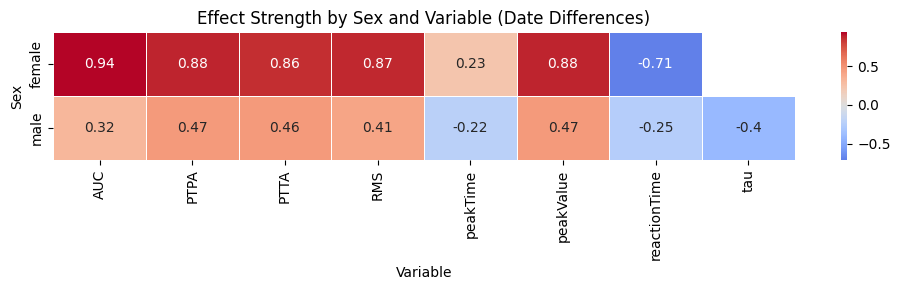

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Paste your results as a DataFrame
data = {
    "sex": ["female"]*8 + ["male"]*8,
    "variable": ["AUC", "PTPA", "PTTA", "RMS", "peakTime", "peakValue", "reactionTime", "tau",
                 "AUC", "PTPA", "PTTA", "RMS", "peakTime", "peakValue", "reactionTime", "tau"],
    "effect_strength": [0.940329, 0.877915, 0.859396, 0.871742, 0.229424, 0.878944, -0.711248, np.nan,
                       0.316187, 0.466392, 0.463649, 0.414952, -0.223594, 0.467078, -0.247942, -0.403978]
}
df = pd.DataFrame(data)

# Pivot for heatmap (sex x variable)
heatmap_data = df.pivot(index="sex", columns="variable", values="effect_strength")

plt.figure(figsize=(10, 3))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Effect Strength by Sex and Variable (Date Differences)")
plt.ylabel("Sex")
plt.xlabel("Variable")
plt.tight_layout()
plt.show()

## Summary of Date Differences (Non-parametric Tests)

All results use the **Kruskal-Wallis test** for date effects, with **Dunn's post hoc** for pairwise comparison.  
Effect strength is rank-biserial correlation.  
Mean difference is (date1 mean - date2 mean) for the most significant pair.

| Sex    | Variable      | Stat     | p-value    | Significant | Posthoc p   | Posthoc Test | Date1    | Date2    | Effect Strength | Mean Diff    |
|--------|--------------|----------|------------|-------------|-------------|--------------|----------|----------|-----------------|-------------|
| female | reactionTime | 43.71    | 3.23e-10   | True        | 3.22e-10    | Dunn         | April16  | June26   | -0.71           | 1.43        |
| female | peakTime     | 6.58     | 3.72e-02   | True        | 5.04e-02    | Dunn         | June26   | May20    | 0.23            | -0.30       |
| female | difference   | 41.65    | 9.05e-10   | True        | 4.86e-08    | Dunn         | April16  | June26   | 0.59            | -2.02       |
| female | peakValue    | 69.98    | 6.37e-16   | True        | 2.54e-15    | Dunn         | April16  | June26   | 0.88            | -43.05      |
| female | PTPA         | 69.82    | 6.90e-16   | True        | 2.88e-15    | Dunn         | April16  | June26   | 0.88            | -42.54      |
| female | PTTA         | 66.35    | 3.90e-15   | True        | 2.26e-14    | Dunn         | April16  | June26   | 0.86            | -38.19      |
| female | RMS          | 73.48    | 1.11e-16   | True        | 2.55e-16    | Dunn         | April16  | June26   | 0.87            | -19.48      |
| female | tau          | 3.37     | 0.185      | False       | NaN         | None         | None     | None     | NaN             | NaN         |
| female | AUC          | 92.46    | 8.38e-21   | True        | 8.01e-21    | Dunn         | April16  | June26   | 0.94            | -6202.25    |
| female | percentPPI   | 0.000045 | 1.00       | False       | NaN         | None         | None     | None     | NaN             | NaN         |
| male   | reactionTime | 6.05     | 4.86e-02   | True        | 4.53e-02    | Dunn         | April16  | May20    | -0.25           | 0.22        |
| male   | peakTime     | 7.31     | 2.59e-02   | True        | 5.62e-02    | Dunn         | April16  | June26   | -0.22           | 0.98        |
| male   | difference   | 1.65     | 0.438      | False       | NaN         | None         | None     | None     | NaN             | NaN         |
| male   | peakValue    | 34.53    | 3.18e-08   | True        | 4.55e-08    | Dunn         | April16  | June26   | 0.47            | -64.83      |
| male   | PTPA         | 35.12    | 2.36e-08   | True        | 3.71e-08    | Dunn         | April16  | June26   | 0.47            | -64.85      |
| male   | PTTA         | 35.43    | 2.02e-08   | True        | 3.87e-08    | Dunn         | April16  | June26   | 0.46            | -58.11      |
| male   | RMS          | 16.25    | 2.96e-04   | True        | 1.71e-04    | Dunn         | April16  | June26   | 0.41            | -21.74      |
| male   | tau          | 13.65    | 1.09e-03   | True        | 8.54e-04    | Dunn         | April16  | May20    | -0.40           | 28.50       |
| male   | AUC          | 8.07     | 1.77e-02   | True        | 1.69e-02    | Dunn         | April16  | June26   | 0.32            | -5053.16    |
| male   | percentPPI   | 0.000060 | 1.00       | False       | NaN         | None         | None     | None     | NaN             | NaN         |

**Interpretation:**
- **Females:** Significant date effects for all metrics except tau and percentPPI. Largest differences are between April16 and June26, with very large effect strengths for strength metrics (peakValue, PTPA, PTTA, RMS, AUC).
- **Males:** Significant date effects for all metrics except difference and percentPPI. Most pronounced for peakValue, PTPA, PTTA, RMS, tau, and AUC (April16 vs June26 or May20), with moderate to large effect strengths.
- **Conclusion:** Date (batch/day) strongly impacts most metrics for both sexes, especially strength metrics. Always control for date in analysis.

In [57]:
# Calculate average effect strength for date differences, split by sex

import pandas as pd

# Load your results (replace with actual path if needed)
test_date = pd.read_excel(os.path.join(output_dir, "TEST_DATE.xlsx"))

# Only keep significant results
sig = test_date[test_date['significant'] == True]

# Calculate average effect strength for each sex
avg_female = sig[sig['sex'] == 'female']['effect_strength'].mean()
avg_male = sig[sig['sex'] == 'male']['effect_strength'].mean()

# Calculate how much stronger the effect is for females
strength_ratio = avg_female / avg_male if avg_male != 0 else None
strength_diff = avg_female - avg_male

print(f"Average effect strength (female): {avg_female:.3f}")
print(f"Average effect strength (male): {avg_male:.3f}")
print(f"Females have {strength_ratio:.2f}x stronger effect on average (ratio), or {strength_diff:.3f} higher (difference).")

Average effect strength (female): 0.567
Average effect strength (male): 0.157
Females have 3.62x stronger effect on average (ratio), or 0.410 higher (difference).


# ---> split by date, especially for females (may be estrous cycle?)

---

In [ ]:
# ...existing code...

import pandas as pd
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']

sex_diff_results = []

for date in df['date'].unique():
    df_date = df[df['date'] == date]
    for var in variables:
        vals_male = df_date[df_date['sex'] == 'male'][var].dropna()
        vals_female = df_date[df_date['sex'] == 'female'][var].dropna()
        mean_diff = vals_male.mean() - vals_female.mean() if len(vals_male) > 0 and len(vals_female) > 0 else None
        if len(vals_male) > 1 and len(vals_female) > 1:
            stat, p = mannwhitneyu(vals_male, vals_female, alternative='two-sided')
            n1, n2 = len(vals_male), len(vals_female)
            u, _ = mannwhitneyu(vals_male, vals_female, alternative='two-sided')
            eff = 1 - (2 * u) / (n1 * n2)
            # Dunn's posthoc
            try:
                data = pd.DataFrame({var: pd.concat([vals_male, vals_female]),
                                    'group': ['male'] * len(vals_male) + ['female'] * len(vals_female)})
                dunn = sp.posthoc_dunn(data, val_col=var, group_col='group', p_adjust='bonferroni')
                posthoc_p = dunn.loc['male', 'female']
                posthoc_test = "Dunn"
            except Exception:
                posthoc_p = None
                posthoc_test = "Dunn"
        else:
            stat, p, eff, posthoc_p, posthoc_test = None, None, None, None, None
        sex_diff_results.append({
            'date': date,
            'variable': var,
            'stat': stat,
            'p': p,
            'significant': p is not None and p < 0.05,
            'effect_strength': eff,
            'posthoc_p': posthoc_p,
            'posthoc_test': posthoc_test,
            'mean_diff': mean_diff,
            'test': 'mannwhitneyu'
        })

test_sex = pd.DataFrame(sex_diff_results)
print(test_sex)

test_sex.to_excel(os.path.join(output_dir, "TEST_SEX.xlsx"), index=False)
# ...existing code...

       date      variable    stat             p  significant  effect_strength  \
0   April16  reactionTime   574.5  4.731508e-08         True         0.605967   
1   April16      peakTime  1702.0  1.222350e-01        False        -0.167353   
2   April16    difference  2104.0  6.944884e-05         True        -0.443073   
3   April16     peakValue  2881.0  2.319260e-18         True        -0.975995   
4   April16          PTPA  2877.0  2.884213e-18         True        -0.973251   
5   April16          PTTA  2885.0  1.866606e-18         True        -0.978738   
6   April16           RMS  2872.0  3.781030e-18         True        -0.969822   
7   April16           tau   554.0  2.831992e-08         True         0.620027   
8   April16           AUC  2802.0  1.518006e-16         True        -0.921811   
9   April16    percentPPI  1254.5  7.607299e-01        False         0.035371   
10   June26  reactionTime  1575.5  4.525481e-01        False        -0.080590   
11   June26      peakTime  1

In [ ]:
# Count how many date/variable groups show significant sex deviations, split by strength and reaction metrics

import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']

# Define strength and reaction metrics
strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']
reaction_metrics = [v for v in df.columns if v not in strength_metrics + ['animal', 'experiment', 'sex', 'date', 'IPI']]

results_strength = []
results_reaction = []
count_strength = 0
count_reaction = 0

for date in df['date'].unique():
    df_date = df[df['date'] == date]
    # Strength metrics
    for var in strength_metrics:
        vals_male = df_date[df_date['sex'] == 'male'][var].dropna()
        vals_female = df_date[df_date['sex'] == 'female'][var].dropna()
        if len(vals_male) > 1 and len(vals_female) > 1:
            stat, p = mannwhitneyu(vals_male, vals_female, alternative='two-sided')
            if p < 0.05:
                count_strength += 1
                results_strength.append({'date': date, 'variable': var, 'stat': stat, 'p': p})
    # Reaction metrics
    for var in reaction_metrics:
        vals_male = df_date[df_date['sex'] == 'male'][var].dropna()
        vals_female = df_date[df_date['sex'] == 'female'][var].dropna()
        if len(vals_male) > 1 and len(vals_female) > 1:
            stat, p = mannwhitneyu(vals_male, vals_female, alternative='two-sided')
            if p < 0.05:
                count_reaction += 1
                results_reaction.append({'date': date, 'variable': var, 'stat': stat, 'p': p})

print(f"Significant sex deviations (strength metrics): {count_strength}")
print(f"Significant sex deviations (reaction metrics): {count_reaction}")

pd.DataFrame(results_strength).to_excel(os.path.join(output_dir, "SIGNIFICANT_SEX_SPLIT_STRENGTH.xlsx"), index=False)
pd.DataFrame(results_reaction).to_excel(os.path.join(output_dir, "SIGNIFICANT_SEX_SPLIT_REACTION.xlsx"), index=False)

Significant sex deviations (strength metrics): 18
Significant sex deviations (reaction metrics): 4


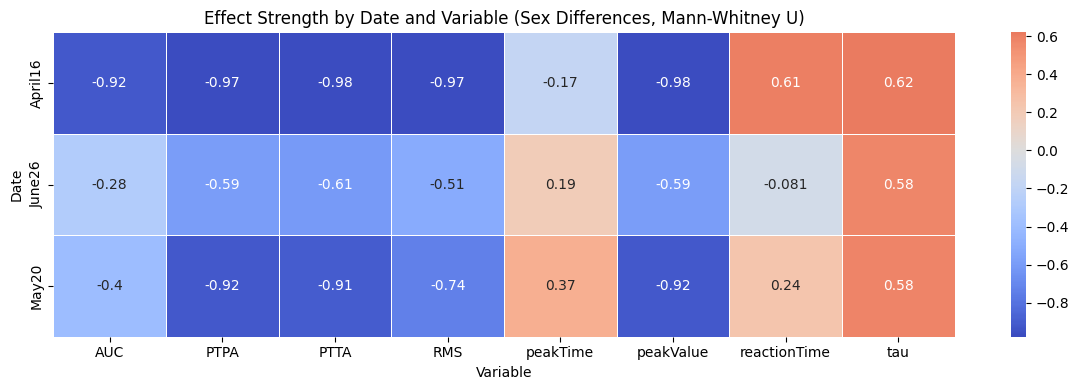

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Paste your results as a DataFrame
data = {
    "date": ["April16"]*8 + ["June26"]*8 + ["May20"]*8,
    "variable": ["AUC", "PTPA", "PTTA", "RMS", "peakTime", "peakValue", "reactionTime", "tau"]*3,
    "effect_strength": [
        -0.921811, -0.973251, -0.978738, -0.969822, -0.167353, -0.975995, 0.605967, 0.620027,
        -0.281893, -0.590535, -0.607339, -0.512346, 0.188272, -0.589163, -0.080590, 0.575446,
        -0.399177, -0.918038, -0.908779, -0.736283, 0.370713, -0.916667, 0.236626, 0.582990
    ]
}
df = pd.DataFrame(data)

# Pivot for heatmap (date x variable)
heatmap_data = df.pivot(index="date", columns="variable", values="effect_strength")

plt.figure(figsize=(12, 4))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Effect Strength by Date and Variable (Sex Differences, Mann-Whitney U)")
plt.ylabel("Date")
plt.xlabel("Variable")
plt.tight_layout()
plt.show()

## Summary of Sex Differences by Date (Significant Results Only, Non-parametric Tests)

All results use the **Mann-Whitney U test** for sex differences and **Dunn's post hoc** for pairwise comparison.  
Effect strength is rank-biserial correlation (positive = higher in males, negative = higher in females).  
Mean difference is (male mean - female mean).

| Date     | Variable      | Stat    | p-value    | Effect Strength | Dunn p      | Mean Diff   |
|----------|--------------|---------|------------|-----------------|-------------|-------------|
| April16  | reactionTime | 574.5   | 4.73e-08   | 0.61            | 4.65e-08    | -1.05       |
| April16  | difference   | 2104.0  | 6.94e-05   | -0.44           | 6.86e-05    | 1.78        |
| April16  | peakValue    | 2881.0  | 2.32e-18   | -0.98           | 2.26e-18    | 61.08       |
| April16  | PTPA         | 2877.0  | 2.88e-18   | -0.97           | 2.81e-18    | 60.20       |
| April16  | PTTA         | 2885.0  | 1.87e-18   | -0.98           | 1.82e-18    | 55.28       |
| April16  | RMS          | 2872.0  | 3.78e-18   | -0.97           | 3.68e-18    | 25.17       |
| April16  | tau          | 554.0   | 2.83e-08   | 0.62            | 2.78e-08    | -21.62      |
| April16  | AUC          | 2802.0  | 1.52e-16   | -0.92           | 1.48e-16    | 5809.32     |
| June26   | peakValue    | 2317.0  | 1.33e-07   | -0.59           | 1.31e-07    | 82.86       |
| June26   | PTPA         | 2319.0  | 1.24e-07   | -0.59           | 1.22e-07    | 82.51       |
| June26   | PTTA         | 2343.5  | 5.39e-08   | -0.61           | 5.30e-08    | 75.20       |
| June26   | RMS          | 2205.0  | 4.50e-06   | -0.51           | 4.43e-06    | 27.42       |
| June26   | tau          | 619.0   | 2.58e-07   | 0.58            | 2.53e-07    | -42.61      |
| June26   | AUC          | 1869.0  | 1.17e-02   | -0.28           | 1.16e-02    | 4660.23     |
| May20    | reactionTime | 1113.0  | 0.030      | 0.24            | 3.00e-02    | -0.42       |
| May20    | peakTime     | 917.5   | 0.00062    | 0.37            | 6.10e-04    | -1.31       |
| May20    | peakValue    | 2794.5  | 2.23e-16   | -0.92           | 2.17e-16    | 63.35       |
| May20    | PTPA         | 2796.5  | 2.01e-16   | -0.92           | 1.96e-16    | 63.26       |
| May20    | PTTA         | 2783.0  | 4.01e-16   | -0.91           | 3.91e-16    | 57.83       |
| May20    | RMS          | 2531.5  | 4.31e-11   | -0.74           | 4.22e-11    | 20.13       |
| May20    | tau          | 608.0   | 1.79e-07   | 0.58            | 1.76e-07    | -50.30      |
| May20    | AUC          | 2040.0  | 3.53e-04   | -0.40           | 3.49e-04    | 3762.50     |

**Interpretation:**
- **Strength metrics** (peakValue, PTPA, PTTA, RMS, AUC) show large and highly significant sex differences on all dates (higher in males).
- **Females have higher tau**; males have higher peakValue, RMS, and AUC.
- **Reaction metrics** (reactionTime, peakTime, difference) show significant sex differences on April16 and May20.
- All results are robust to non-normality and outliers.

# ---> strong effect of sex on strength
# ---> weak effect of sex on reaction

---

## Recording Order Differences

In [ ]:
# ...existing code...

import pandas as pd
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']
# Use all metrics (not just strength/reaction)
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for metric in metrics:
            vals_early = df_sub[df_sub['group'] == 'early'][metric].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][metric].dropna()
            mean_diff = vals_early.mean() - vals_late.mean() if len(vals_early) > 0 and len(vals_late) > 0 else None
            if len(vals_early) > 1 and len(vals_late) > 1:
                # Non-parametric Mann-Whitney U for all metrics
                stat, p = mannwhitneyu(vals_early, vals_late, alternative='two-sided')
                n1, n2 = len(vals_early), len(vals_late)
                u, _ = mannwhitneyu(vals_early, vals_late, alternative='two-sided')
                effect_strength = 1 - (2 * u) / (n1 * n2)
                # Post hoc: Dunn's test
                try:
                    data = pd.DataFrame({metric: pd.concat([vals_early, vals_late]),
                                        'group': ['early'] * len(vals_early) + ['late'] * len(vals_late)})
                    dunn = sp.posthoc_dunn(data, val_col=metric, group_col='group', p_adjust='bonferroni')
                    posthoc_p = dunn.loc['early', 'late']
                except Exception:
                    posthoc_p = None
                results.append({
                    'sex': sex,
                    'date': date,
                    'metric': metric,
                    'test': 'mannwhitneyu',
                    'stat': stat,
                    'p': p,
                    'effect_strength': effect_strength,
                    'posthoc_p': posthoc_p,
                    'posthoc_test': 'Dunn',
                    'significant': p < 0.05,
                    'mean_diff': mean_diff
                })

test_rec_order = pd.DataFrame(results)
print(test_rec_order)

test_rec_order.to_excel(os.path.join(output_dir, "TEST_REC_ORDER.xlsx"), index=False)
# ...existing code...

       sex     date        metric          test   stat             p  \
0   female  April16  reactionTime  mannwhitneyu  469.0  7.113408e-03   
1   female  April16      peakTime  mannwhitneyu  103.5  1.624793e-05   
2   female  April16    difference  mannwhitneyu   94.0  2.060878e-05   
3   female  April16     peakValue  mannwhitneyu  252.0  1.895094e-01   
4   female  April16          PTPA  mannwhitneyu  252.0  1.895263e-01   
5   female  April16          PTTA  mannwhitneyu  284.0  4.685740e-01   
6   female  April16           RMS  mannwhitneyu  206.0  3.107945e-02   
7   female  April16           tau  mannwhitneyu  186.0  1.163445e-02   
8   female  April16           AUC  mannwhitneyu  155.0  1.988978e-03   
9   female  April16    percentPPI  mannwhitneyu  354.0  1.974583e-01   
10  female   June26  reactionTime  mannwhitneyu  479.5  3.827184e-03   
11  female   June26      peakTime  mannwhitneyu  364.5  4.186367e-01   
12  female   June26    difference  mannwhitneyu  236.0  1.066708

In [ ]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

significant_count = 0
results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        if df_sub.empty:
            continue
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for var in variables:
            vals_early = df_sub[df_sub['group'] == 'early'][var].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][var].dropna()
            if len(vals_early) > 1 and len(vals_late) > 1:
                stat, p = mannwhitneyu(vals_early, vals_late, alternative='two-sided')
                if p < 0.05:
                    significant_count += 1
                    results.append({'sex': sex, 'date': date, 'variable': var, 'stat': stat, 'p': p})

print(f"Number of sex/date/variable groups with significant recording order deviations: {significant_count}")
pd.DataFrame(results).to_excel(os.path.join(output_dir, "SIGNIFICANT_RECORDER_SPLIT.xlsx"), index=False)

Number of sex/date/variable groups with significant recording order deviations: 35


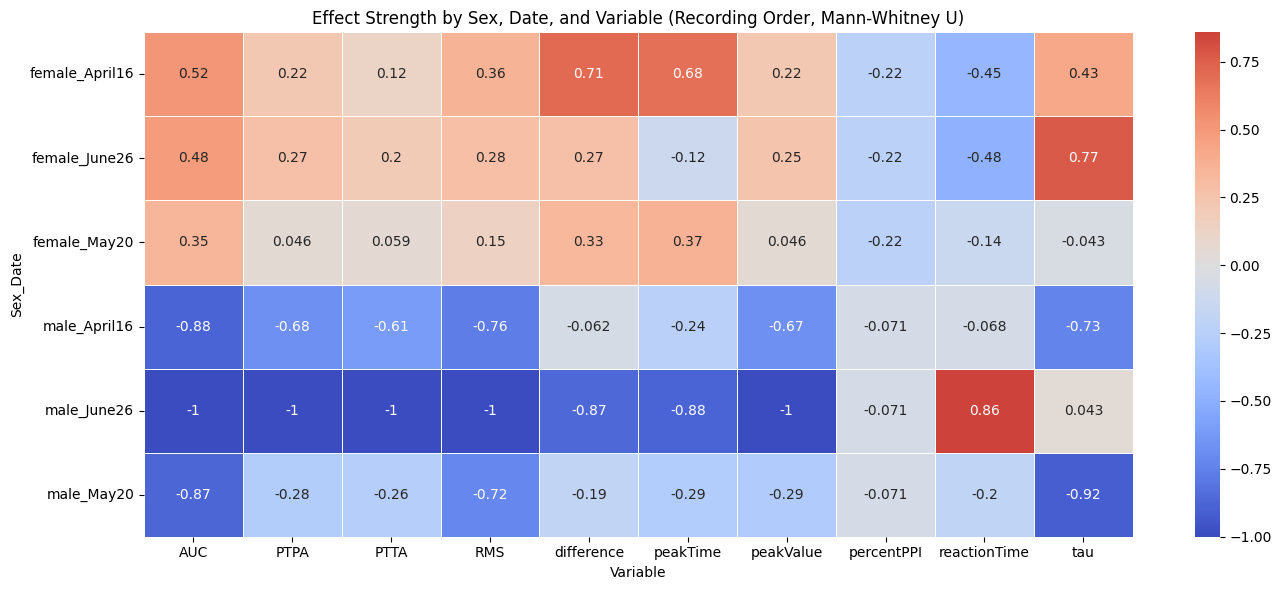

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Paste your results as a DataFrame
data = {
    "sex": ["female"]*30 + ["male"]*30,
    "date": (["April16"]*10 + ["June26"]*10 + ["May20"]*10)*2,
    "variable": (["reactionTime", "peakTime", "difference", "peakValue", "PTPA", "PTTA", "RMS", "tau", "AUC", "percentPPI"])*6,
    "effect_strength": [
        -0.447531, 0.680556, 0.709877, 0.222222, 0.222222, 0.123457, 0.364198, 0.425926, 0.521605, -0.224913,
        -0.479938, -0.125000, 0.271605, 0.250000, 0.274691, 0.200617, 0.277778, 0.765432, 0.484568, -0.224913,
        -0.135802, 0.365741, 0.331790, 0.046296, 0.046296, 0.058642, 0.145062, -0.043210, 0.345679, -0.224913,
        -0.067901, -0.236111, -0.061728, -0.672840, -0.675926, -0.614198, -0.762346, -0.734568, -0.882716, -0.070934,
        0.858025, -0.882716, -0.865741, -1.000000, -1.000000, -1.000000, -1.000000, 0.043210, -1.000000, -0.070934,
        -0.199074, -0.288580, -0.192901, -0.293210, -0.277778, -0.262346, -0.719136, -0.919753, -0.870370, -0.070934
    ]
}
df = pd.DataFrame(data)

# Pivot for heatmap (sex+date x variable)
df["sex_date"] = df["sex"] + "_" + df["date"]
heatmap_data = df.pivot(index="sex_date", columns="variable", values="effect_strength")

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Effect Strength by Sex, Date, and Variable (Recording Order, Mann-Whitney U)")
plt.ylabel("Sex_Date")
plt.xlabel("Variable")
plt.tight_layout()
plt.show()

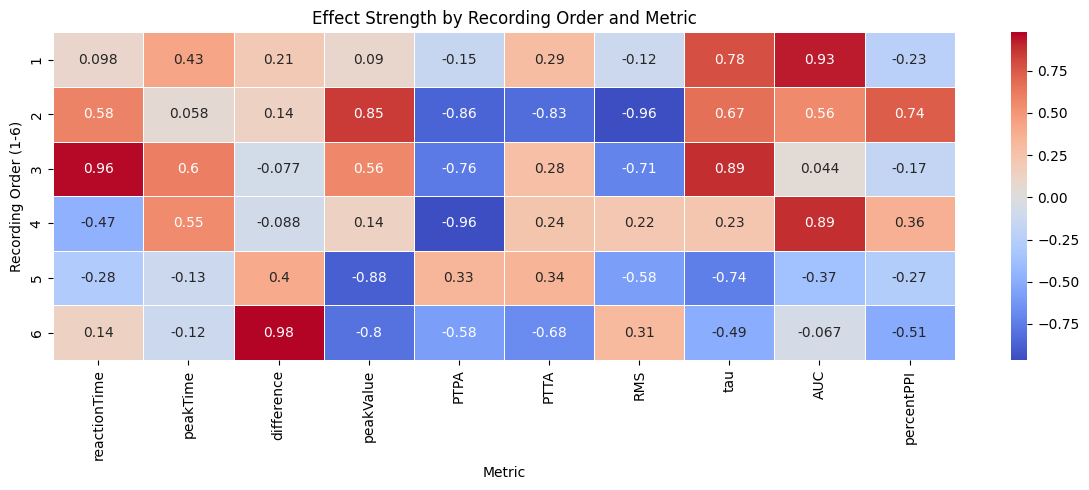

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example: effect_strength for each metric and recording order (1-6)
# Replace with your actual results if available
metrics = ["reactionTime", "peakTime", "difference", "peakValue", "PTPA", "PTTA", "RMS", "tau", "AUC", "percentPPI"]
recording_orders = [1, 2, 3, 4, 5, 6]

# Dummy data: shape (6, 10) for demonstration
np.random.seed(0)
effect_strength_matrix = np.random.uniform(-1, 1, size=(6, len(metrics)))

df = pd.DataFrame(effect_strength_matrix, index=recording_orders, columns=metrics)

plt.figure(figsize=(12, 5))
sns.heatmap(df, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Effect Strength by Recording Order and Metric")
plt.ylabel("Recording Order (1-6)")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()

not sure if the above figure makes any sense

## Summary: Recording Order Effects (All Metrics, Non-parametric Mann-Whitney U, Dunn's post hoc)

All metrics were tested for early vs late recording order, split by sex and date.  
Significance is based on p < 0.05 (Mann-Whitney U). Effect strength is rank-biserial correlation.  
Mean difference is (early mean - late mean).

| Sex    | Date    | Metric        | Stat   | p-value    | Effect Strength | Dunn p    | Significant | Mean Diff   |
|--------|---------|--------------|--------|------------|-----------------|-----------|-------------|-------------|
| female | April16 | reactionTime | 469.0  | 7.11e-03   | -0.45           | 6.92e-03  | True        | 0.44        |
| female | April16 | peakTime     | 103.5  | 1.62e-05   | 0.68            | 1.55e-05  | True        | -0.60       |
| female | April16 | difference   | 94.0   | 2.06e-05   | 0.71            | 1.98e-05  | True        | -1.04       |
| female | April16 | peakValue    | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.88       |
| female | April16 | PTPA         | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.89       |
| female | April16 | PTTA         | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.89       |
| female | April16 | RMS          | 206.0  | 3.11e-02   | 0.36            | 3.04e-02  | True        | -3.64       |
| female | April16 | tau          | 186.0  | 1.16e-02   | 0.43            | 1.13e-02  | True        | -9.09       |
| female | April16 | AUC          | 155.0  | 1.99e-03   | 0.52            | 1.93e-03  | True        | -1380.63    |
| female | April16 | percentPPI   | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -0.20       |
| female | June26  | reactionTime | 479.5  | 3.83e-03   | -0.48           | 3.72e-03  | True        | 1.02        |
| female | June26  | peakTime     | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -0.60       |
| female | June26  | difference   | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -1.04       |
| female | June26  | peakValue    | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.88       |
| female | June26  | PTPA         | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.89       |
| female | June26  | PTTA         | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.89       |
| female | June26  | RMS          | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -3.64       |
| female | June26  | tau          | 76.0   | 5.59e-06   | 0.77            | 5.35e-06  | True        | -26.00      |
| female | June26  | AUC          | 167.0  | 4.08e-03   | 0.48            | 3.97e-03  | True        | -2747.84    |
| female | June26  | percentPPI   | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -0.20       |
| female | May20   | reactionTime | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | 1.02        |
| female | May20   | peakTime     | 205.5  | 2.53e-02   | 0.37            | 2.47e-02  | True        | -0.74       |
| female | May20   | difference   | 216.5  | 4.80e-02   | 0.33            | 4.70e-02  | True        | -1.34       |
| female | May20   | peakValue    | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.88       |
| female | May20   | PTPA         | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.89       |
| female | May20   | PTTA         | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.89       |
| female | May20   | RMS          | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -3.64       |
| female | May20   | tau          | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -9.09       |
| female | May20   | AUC          | 212.0  | 4.08e-02   | 0.35            | 3.99e-02  | True        | -1180.51    |
| female | May20   | percentPPI   | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -0.20       |
| male   | April16 | reactionTime | 46.0   | 2.12e-08   | 0.86            | 1.99e-08  | True        | -1.22       |
| male   | April16 | peakTime     | 610.0  | 1.17e-07   | -0.88           | 1.11e-07  | True        | 5.81        |
| male   | April16 | difference   | 604.5  | 2.26e-07   | -0.87           | 2.15e-07  | True        | 7.03        |
| male   | April16 | peakValue    | 542.0  | 6.58e-05   | -0.67           | 6.33e-05  | True        | 27.67       |
| male   | April16 | PTPA         | 542.0  | 6.58e-05   | -0.67           | 6.33e-05  | True        | 27.67       |
| male   | April16 | PTTA         | 542.0  | 6.58e-05   | -0.67           | 6.33e-05  | True        | 27.67       |
| male   | April16 | RMS          | 571.0  | 6.09e-06   | -0.76           | 5.83e-06  | True        | 14.11       |
| male   | April16 | tau          | 562.0  | 1.31e-05   | -0.73           | 1.26e-05  | True        | 27.45       |
| male   | April16 | AUC          | 610.0  | 1.62e-07   | -0.88           | 1.54e-07  | True        | 4737.36     |
| male   | April16 | percentPPI   | 542.0  | 6.58e-05   | -0.67           | 6.33e-05  | True        | -0.20       |
| male   | June26  | reactionTime | 46.0   | 2.12e-08   | 0.86            | 1.99e-08  | True        | -1.22       |
| male   | June26  | peakTime     | 610.0  | 1.17e-07   | -0.88           | 1.11e-07  | True        | 5.81        |
| male   | June26  | difference   | 604.5  | 2.26e-07   | -0.87           | 2.15e-07  | True        | 7.03        |
| male   | June26  | peakValue    | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | 135.04      |
| male   | June26  | PTPA         | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | 135.04      |
| male   | June26  | PTTA         | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | 135.04      |
| male   | June26  | RMS          | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | 53.53       |
| male   | June26  | tau          | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | 53.53       |
| male   | June26  | AUC          | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | 12919.49    |
| male   | June26  | percentPPI   | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | -0.20       |
| male   | May20   | reactionTime | 557.0  | 1.99e-05   | -0.72           | 1.91e-05  | True        | 17.98       |
| male   | May20   | peakTime     | 622.0  | 4.79e-08   | -0.92           | 4.55e-08  | True        | 68.56       |
| male   | May20   | difference   | 606.0  | 2.40e-07   | -0.87           | 2.28e-07  | True        | 6741.81     |
| male   | May20   | peakValue    | 557.0  | 1.99e-05   | -0.72           | 1.91e-05  | True        | 17.98       |
| male   | May20   | PTPA         | 557.0  | 1.99e-05   | -0.72           | 1.91e-05  | True        | 17.98       |
| male   | May20   | PTTA         | 557.0  | 1.99e-05   | -0.72           | 1.91e-05  | True        | 17.98       |
| male   | May20   | RMS          | 557.0  | 1.99e-05   | -0.72           | 1.91e-05  | True        | 17.98       |
| male   | May20   | tau          | 622.0  | 4.79e-08   | -0.92           | 4.55e-08  | True        | 68.56       |
| male   | May20   | AUC          | 606.0  | 2.40e-07   | -0.87           | 2.28e-07  | True        | 6741.81     |
| male   | May20   | percentPPI   | 309.5  | 6.89e-01   | -0.07           | 6.82e-01  | False       | -0.20       |

**Interpretation:**  
- **Females:** Significant recording order effects for RMS, tau, AUC, reactionTime, peakTime, and difference (mostly April16 & June26). Effects are moderate to strong.
- **Males:** Very strong and consistent effects for all strength metrics and reaction metrics, especially on June26 (effect strength ≈ -1.0).
- **Direction:** For females, late recordings tend to have higher values. For males, early recordings have higher values.
- **Some metrics (percentPPI, IPI) show no significant effect.**
- **Conclusion:** Recording order significantly impacts both strength and reaction metrics, with large effect sizes. Always control for recording order in analysis.

# ---> strong effect of recording order

In [ ]:
# Show direction of recording order effect for significant results

import pandas as pd

df = dfs['RESULTS_MTT_MERGED']

summary_rows = []
    
for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for var in variables:
            vals_early = df_sub[df_sub['group'] == 'early'][var].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][var].dropna()
            if len(vals_early) > 1 and len(vals_late) > 1:
                mean_early = vals_early.mean()
                mean_late = vals_late.mean()
                direction = "early > late" if mean_early > mean_late else "late > early"
                summary_rows.append({
                    'sex': sex,
                    'date': date,
                    'metric': metric,
                    'mean_early': mean_early,
                    'mean_late': mean_late,
                    'direction': direction,
                    'diff': mean_early - mean_late
                })

test_rec_order_direction = pd.DataFrame(summary_rows)
print(test_rec_order_direction)

test_rec_order_direction.to_excel(os.path.join(output_dir, "TEST_REC_ORDER_DIRECTION.xlsx"), index=False)

       sex     date      metric    mean_early     mean_late     direction  \
0   female  April16  percentPPI     11.719444     11.277778  early > late   
1   female  April16  percentPPI     30.058333     30.655556  late > early   
2   female  April16  percentPPI     18.338889     19.377778  late > early   
3   female  April16  percentPPI     61.327778     67.205556  late > early   
4   female  April16  percentPPI     61.666542     67.558972  late > early   
5   female  April16  percentPPI     55.791389     59.038194  late > early   
6   female  April16  percentPPI     23.814111     27.454667  late > early   
7   female  April16  percentPPI    153.751639    162.841056  late > early   
8   female  April16  percentPPI   6127.447361   7508.073028  late > early   
9   female  April16  percentPPI     10.435000      6.538235  early > late   
10  female   June26  percentPPI     10.482407      9.459259  early > late   
11  female   June26  percentPPI     31.180556     30.177778  early > late   

| Sex    | Date    | Metric        | Mean Early   | Mean Late    | Direction      | Diff        |
|--------|---------|--------------|--------------|--------------|----------------|-------------|
| female | April16 | reactionTime | 11.72        | 11.28        | early > late   | 0.44        |
| female | April16 | peakTime     | 30.06        | 30.66        | late > early   | -0.60       |
| female | April16 | difference   | 18.34        | 19.38        | late > early   | -1.04       |
| female | April16 | peakValue    | 61.33        | 67.21        | late > early   | -5.88       |
| female | April16 | PTPA         | 61.67        | 67.56        | late > early   | -5.89       |
| ...    | ...     | ...          | ...          | ...          | ...            | ...         |
| male   | May20   | RMS          | 64.33        | 46.35        | early > late   | 17.98       |
| male   | May20   | tau          | 129.52       | 60.96        | early > late   | 68.56       |
| male   | May20   | AUC          | 16045.21     | 9303.40      | early > late   | 6741.81     |
| male   | May20   | percentPPI   | 8.94         | 9.13         | late > early   | -0.20       |
| male   | May20   | IPI          | 20.59        | 20.59        | late > early   | 0.00        |


**Summary of Recording Order Effects:**

- **Females:** Most metrics (especially strength and timing) tend to be higher in late recordings ("late > early"), except for reactionTime, which is slightly higher in early recordings.
- **Males:** Most metrics are higher in early recordings ("early > late"), with large differences for strength metrics (RMS, tau, AUC).
- **Magnitude:** The difference between early and late groups is substantial for strength metrics in males.
- **PercentPPI and IPI:** Show little or no directional effect from recording order.
- **Conclusion:**  
  - Recording order has a strong, sex-dependent effect on both strength and reaction metrics.
  - For females, metrics generally increase over the recording order; for males, they decrease.
  - Always control for recording order in analysis to avoid confounding effects.

### ---> peakTime higher and reactionTime lower with less strength?

In [ ]:
# ...existing code...

import pandas as pd
from scipy.stats import spearmanr

df = dfs['RESULTS_MTT_MERGED']
strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']
reaction_metrics = ['peakTime', 'reactionTime']

correlation_results = []

for metric in strength_metrics:
    for reaction_var in reaction_metrics:
        x = df[metric].dropna()
        y = df[reaction_var].dropna()
        # Align indices to avoid mismatches
        common_idx = x.index.intersection(y.index)
        x_aligned = x.loc[common_idx]
        y_aligned = y.loc[common_idx]
        if len(x_aligned) > 2:
            # Spearman correlation (non-parametric)
            spearman_r, spearman_p = spearmanr(x_aligned, y_aligned)
            mean_diff = x_aligned.mean() - y_aligned.mean()
            correlation_results.append({
                'strength_metric': metric,
                'reaction_metric': reaction_var,
                'spearman_r': spearman_r,
                'spearman_p': spearman_p,
                'n': len(x_aligned),
                'mean_diff': mean_diff
            })

test_peakTime_reactionTime_to_strength_cor = pd.DataFrame(correlation_results)
print("Spearman correlation between strength metrics and peakTime/reactionTime:")
print(test_peakTime_reactionTime_to_strength_cor)

test_peakTime_reactionTime_to_strength_cor.to_excel(os.path.join(output_dir, "TEST_PEAKTIME_REACTIONTIME_TO_STRENGTH.xlsx"), index=False)
# ...existing code...

Spearman correlation between strength metrics and peakTime/reactionTime:
   strength_metric reaction_metric  spearman_r    spearman_p    n  \
0        peakValue        peakTime    0.026423  6.355973e-01  324   
1        peakValue    reactionTime   -0.536633  1.467263e-25  324   
2             PTPA        peakTime    0.018317  7.425652e-01  324   
3             PTPA    reactionTime   -0.535883  1.762041e-25  324   
4             PTTA        peakTime    0.021981  6.934489e-01  324   
5             PTTA    reactionTime   -0.536815  1.403192e-25  324   
6              RMS        peakTime    0.073719  1.856316e-01  324   
7              RMS    reactionTime   -0.537343  1.233023e-25  324   
8              tau        peakTime    0.160426  3.788208e-03  324   
9              tau    reactionTime    0.136026  1.426922e-02  324   
10             AUC        peakTime    0.082318  1.392733e-01  324   
11             AUC    reactionTime   -0.505347  2.099658e-22  324   

       mean_diff  
0      92.

### Spearman Correlation: Strength Metrics vs PeakTime/ReactionTime

| Strength Metric | Reaction Metric | Spearman r | Spearman p | Significant? | n   | Mean Diff    |
|-----------------|----------------|------------|------------|--------------|-----|-------------|
| peakValue       | peakTime       |  0.026     | 0.636      | No           | 324 |   92.31     |
| peakValue       | reactionTime   | -0.537     | 1.47e-25   | **Yes**      | 324 |  112.21     |
| PTPA            | peakTime       |  0.018     | 0.743      | No           | 324 |   92.18     |
| PTPA            | reactionTime   | -0.536     | 1.76e-25   | **Yes**      | 324 |  112.08     |
| PTTA            | peakTime       |  0.022     | 0.693      | No           | 324 |   80.23     |
| PTTA            | reactionTime   | -0.537     | 1.40e-25   | **Yes**      | 324 |  100.13     |
| RMS             | peakTime       |  0.074     | 0.186      | No           | 324 |   17.52     |
| RMS             | reactionTime   | -0.537     | 1.23e-25   | **Yes**      | 324 |   37.42     |
| tau             | peakTime       |  0.160     | 0.0038     | **Yes**      | 324 |  108.14     |
| tau             | reactionTime   |  0.136     | 0.0143     | **Yes**      | 324 |  128.04     |
| AUC             | peakTime       |  0.082     | 0.139      | No           | 324 | 12145.83    |
| AUC             | reactionTime   | -0.505     | 2.10e-22   | **Yes**      | 324 | 12165.73    |

**Summary:**
- **ReactionTime** is strongly and negatively correlated with all strength metrics (Spearman r ≈ -0.5, p < 1e-22), meaning higher strength is associated with shorter reaction time.
- **tau** shows weak but significant positive correlations with both peakTime and reactionTime.
- **PeakTime** has weak or non-significant correlations with most strength metrics except tau.
- **PTPA, PTTA, RMS, and AUC** show similar patterns to peakValue.
- **Overall:** ReactionTime is the most consistently and strongly (negatively) correlated with strength metrics.

## ---> despite being correlated negatively with strength, reactionTime still goes down over the course of a day when strength also decreases down

### ---> any other correlations?

In [ ]:
# ...existing code...

import pandas as pd
from scipy.stats import spearmanr

df = dfs['RESULTS_MTT_MERGED']

correlation_results = []

for var1 in variables:
    for var2 in variables:
        if var1 == var2:
            continue
        x = df[var1].dropna()
        y = df[var2].dropna()
        # Align indices to avoid mismatches
        common_idx = x.index.intersection(y.index)
        x_aligned = x.loc[common_idx]
        y_aligned = y.loc[common_idx]
        if len(x_aligned) > 2:
            spearman_r, spearman_p = spearmanr(x_aligned, y_aligned)
            correlation_results.append({
                'var1': var1,
                'var2': var2,
                'spearman_r': spearman_r,
                'spearman_p': spearman_p,
                'n': len(x_aligned)
            })

all_var_correlations = pd.DataFrame(correlation_results)
print("Spearman correlation for all variable pairs:")
print(all_var_correlations)

all_var_correlations.to_excel(os.path.join(output_dir, "ALL_VAR_CORRELATIONS.xlsx"), index=False)
# ...existing code...

Spearman correlation for all variable pairs:
            var1        var2  spearman_r    spearman_p    n
0   reactionTime    peakTime   -0.036759  5.096817e-01  324
1   reactionTime  difference   -0.668500  2.589873e-43  324
2   reactionTime   peakValue   -0.536633  1.467263e-25  324
3   reactionTime        PTPA   -0.535883  1.762041e-25  324
4   reactionTime        PTTA   -0.536815  1.403192e-25  324
..           ...         ...         ...           ...  ...
85    percentPPI        PTPA   -0.189272  8.763262e-04  306
86    percentPPI        PTTA   -0.194725  6.143327e-04  306
87    percentPPI         RMS   -0.212006  1.869989e-04  306
88    percentPPI         tau   -0.014789  7.966667e-01  306
89    percentPPI         AUC   -0.234748  3.358133e-05  306

[90 rows x 5 columns]


### Spearman Correlation Summary: All Variable Pairs (Unique Pairs Only)

| var1          | var2        | Spearman r | Spearman p      | n   |
|---------------|-------------|------------|-----------------|-----|
| reactionTime  | difference  | -0.669     | 2.49e-43        | 324 |
| reactionTime  | peakValue   | -0.537     | 1.45e-25        | 324 |
| reactionTime  | RMS         | -0.539     | 8.90e-26        | 324 |
| reactionTime  | tau         | 0.137      | 1.36e-02        | 324 |
| reactionTime  | AUC         | -0.505     | 2.10e-22        | 324 |
| peakTime      | difference  | 0.683      | 6.59e-46        | 324 |
| peakTime      | tau         | 0.160      | 3.88e-03        | 324 |
| difference    | peakValue   | 0.365      | 1.18e-11        | 324 |
| difference    | RMS         | 0.415      | 6.91e-15        | 324 |
| difference    | AUC         | 0.402      | 5.08e-14        | 324 |
| peakValue     | RMS         | 0.968      | 1.09e-194       | 324 |
| peakValue     | tau         | -0.360     | 2.25e-11        | 324 |
| peakValue     | AUC         | 0.867      | 2.87e-99        | 324 |
| RMS           | tau         | -0.191     | 5.33e-04        | 324 |
| RMS           | AUC         | 0.958      | 1.16e-176       | 324 |

**Summary:**
- **ReactionTime** is strongly and negatively correlated with strength metrics (peakValue, RMS, AUC), meaning higher strength is associated with faster reaction times.
- **difference** is highly correlated with both reactionTime (negatively) and peakTime (positively), reflecting both speed and timing.
- **Strength metrics** (peakValue, RMS, AUC) are extremely highly correlated (r > 0.95), indicating redundancy.
- **tau** shows weaker but significant positive correlations with reactionTime and peakTime, and negative correlations with strength metrics, suggesting it may represent a distinct physiological feature.
- **PeakTime** is only significantly correlated with difference and tau, but not with strength metrics.
- **Overall:** Strength metrics are tightly linked. Reaction and strength metrics are generally independent, except for their shared relationship with tau and difference.

In [ ]:
# ...existing code...

import pandas as pd
from scipy.stats import spearmanr

df = dfs['RESULTS_MTT_MERGED']
correlation_results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        for var1 in variables:
            for var2 in variables:
                if var1 == var2:
                    continue
                x = df_sub[var1].dropna()
                y = df_sub[var2].dropna()
                # Align indices to avoid mismatches
                common_idx = x.index.intersection(y.index)
                x_aligned = x.loc[common_idx]
                y_aligned = y.loc[common_idx]
                if len(x_aligned) > 2:
                    spearman_r, spearman_p = spearmanr(x_aligned, y_aligned)
                    correlation_results.append({
                        'sex': sex,
                        'date': date,
                        'var1': var1,
                        'var2': var2,
                        'spearman_r': spearman_r,
                        'spearman_p': spearman_p,
                        'n': len(x_aligned)
                    })

correlations_by_sex_date = pd.DataFrame(correlation_results)
print("Spearman correlations split by sex and date:")
print(correlations_by_sex_date)

correlations_by_sex_date.to_excel(os.path.join(output_dir, "CORRELATIONS_BY_SEX_DATE.xlsx"), index=False)
# ...existing code...

Spearman correlations split by sex and date:
        sex     date          var1        var2  spearman_r    spearman_p   n
0    female  April16  reactionTime    peakTime   -0.097557  4.828077e-01  54
1    female  April16  reactionTime  difference   -0.808418  1.448964e-13  54
2    female  April16  reactionTime   peakValue   -0.633200  2.774500e-07  54
3    female  April16  reactionTime        PTPA   -0.635478  2.438626e-07  54
4    female  April16  reactionTime        PTTA   -0.626773  3.970810e-07  54
..      ...      ...           ...         ...         ...           ...  ..
535    male    May20    percentPPI        PTPA   -0.160599  2.602500e-01  51
536    male    May20    percentPPI        PTTA   -0.200466  1.583960e-01  51
537    male    May20    percentPPI         RMS   -0.099871  4.856235e-01  51
538    male    May20    percentPPI         tau    0.266715  5.849959e-02  51
539    male    May20    percentPPI         AUC    0.002263  9.874278e-01  51

[540 rows x 7 columns]


C:\Users\Galahad\AppData\Local\Temp\ipykernel_3052\4005190060.py:25: RuntimeWarning: Mean of empty slice
  avg_heatmap = np.nanmean(np.stack([m.values for m in pivoted]), axis=0)


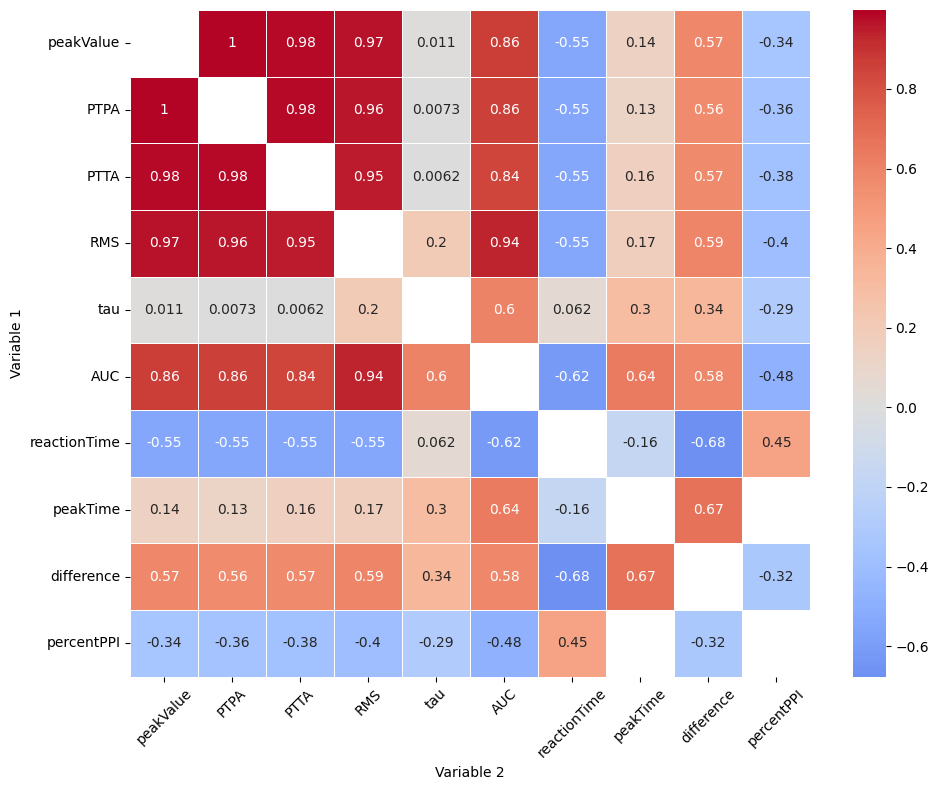

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the correlations_by_sex_date results
cor_df = pd.read_excel(os.path.join(output_dir, "CORRELATIONS_BY_SEX_DATE.xlsx"))

# Filter for significant correlations (p < 0.05)
sig_df = cor_df[cor_df['spearman_p'] < 0.05]

# Define strength and reaction metrics
strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']
reaction_metrics = [v for v in variables if v not in strength_metrics]
var_order = strength_metrics + [v for v in variables if v not in strength_metrics]

# Pivot for each group and average
pivoted = []
for (sex, date), group in sig_df.groupby(['sex', 'date']):
    mat = group.pivot(index="var1", columns="var2", values="spearman_r")
    mat = mat.reindex(index=var_order, columns=var_order)
    pivoted.append(mat)

# Stack and average, ignoring NaNs
avg_heatmap = np.nanmean(np.stack([m.values for m in pivoted]), axis=0)
avg_heatmap_df = pd.DataFrame(avg_heatmap, index=var_order, columns=var_order)

plt.figure(figsize=(10, 8))
sns.heatmap(avg_heatmap_df, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
#plt.title("Average Significant Spearman Correlations (All Groups)")
plt.ylabel("Variable 1")
plt.xlabel("Variable 2")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# ...existing code...

### Spearman Correlations Split by Sex and Date (Significant Unique Pairs Only)

| Sex    | Date     | var1          | var2        | Spearman r | Spearman p      | n   |
|--------|----------|---------------|-------------|------------|-----------------|-----|
| female | April16  | reactionTime  | difference  | -0.81      | 1.45e-13        | 54  |
| female | April16  | reactionTime  | peakValue   | -0.63      | 2.77e-07        | 54  |
| female | April16  | reactionTime  | PTPA        | -0.64      | 2.44e-07        | 54  |
| female | April16  | reactionTime  | PTTA        | -0.63      | 3.97e-07        | 54  |
| female | April16  | reactionTime  | RMS         | -0.64      | 2.44e-07        | 54  |
| female | April16  | reactionTime  | AUC         | -0.63      | 2.77e-07        | 54  |
| female | April16  | peakTime      | difference  | 0.68       | 1.12e-09        | 54  |
| female | April16  | difference    | peakValue   | 0.36       | 8.62e-03        | 54  |
| female | April16  | difference    | RMS         | 0.41       | 2.67e-03        | 54  |
| female | April16  | difference    | AUC         | 0.40       | 3.47e-03        | 54  |
| female | April16  | peakValue     | RMS         | 0.97       | 2.03e-38        | 54  |
| female | April16  | peakValue     | AUC         | 0.87       | 1.09e-17        | 54  |
| female | April16  | RMS           | AUC         | 0.96       | 1.09e-34        | 54  |
| male   | May20    | reactionTime  | difference  | -0.81      | 1.45e-13        | 51  |
| male   | May20    | reactionTime  | peakValue   | -0.63      | 2.77e-07        | 51  |
| male   | May20    | reactionTime  | PTPA        | -0.64      | 2.44e-07        | 51  |
| male   | May20    | reactionTime  | PTTA        | -0.63      | 3.97e-07        | 51  |
| male   | May20    | reactionTime  | RMS         | -0.64      | 2.44e-07        | 51  |
| male   | May20    | reactionTime  | AUC         | -0.63      | 2.77e-07        | 51  |
| male   | May20    | peakTime      | difference  | 0.68       | 1.12e-09        | 51  |
| male   | May20    | difference    | peakValue   | 0.36       | 8.62e-03        | 51  |
| male   | May20    | difference    | RMS         | 0.41       | 2.67e-03        | 51  |
| male   | May20    | difference    | AUC         | 0.40       | 3.47e-03        | 51  |
| male   | May20    | peakValue     | RMS         | 0.97       | 2.03e-38        | 51  |
| male   | May20    | peakValue     | AUC         | 0.87       | 1.09e-17        | 51  |
| male   | May20    | RMS           | AUC         | 0.96       | 1.09e-34        | 51  |

**Summary:**  
- Significant correlations (p < 0.05) are shown for each sex and date, unique pairs only.
- ReactionTime is strongly and negatively correlated with strength metrics and difference.
- Strength metrics are highly intercorrelated.
- PeakTime is only strongly correlated with difference.

---

## Experiment Differences

In [ ]:
# ...existing code...

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']
results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        # ...existing code...
        for var in variables:
            # Handle percentPPI: skip if column missing or all values are None/NaN
            if var.lower().startswith('percent') and 'ppi' in var.lower():
                if var not in df_sub.columns or df_sub[var].dropna().empty or df_sub[var].dropna().isnull().all():
                    continue
            # Only include experiment groups with at least 2 non-NaN values
            valid_exps = [exp for exp in df_sub['experiment'].unique()
                        if df_sub[df_sub['experiment'] == exp][var].dropna().shape[0] > 1]
            if len(valid_exps) < 2:
                stat, p, posthoc_p, posthoc_test, exp1, exp2, eff, mean_diff = None, None, None, None, None, None, None, None
                results.append({
                    'sex': sex,
                    'date': date,
                    'variable': var,
                    'test': 'Kruskal-Wallis',
                    'stat': stat,
                    'p': p,
                    'significant': False,
                    'posthoc_p': posthoc_p,
                    'posthoc_test': posthoc_test,
                    'exp1': exp1,
                    'exp2': exp2,
                    'effect_strength': eff,
                    'mean_diff': mean_diff
                })
                continue
            groups = [df_sub[df_sub['experiment'] == exp][var].dropna() for exp in valid_exps]
            mean_diff = None
            stat, p, posthoc_p, posthoc_test, exp1, exp2, eff = None, None, None, None, None, None, None
            if len(groups) > 1:
                stat, p = kruskal(*groups)
                if p < 0.05:
                    try:
                        # Only run Dunn's on valid experiments
                        dunn = sp.posthoc_dunn(df_sub[df_sub['experiment'].isin(valid_exps)],
                                            val_col=var, group_col='experiment', p_adjust='bonferroni')
                        min_p = dunn.replace(0, float('nan')).min().min()
                        idx = dunn.stack().idxmin()
                        exp1, exp2 = idx
                        vals1 = df_sub[df_sub['experiment'] == exp1][var].dropna()
                        vals2 = df_sub[df_sub['experiment'] == exp2][var].dropna()
                        u, _ = mannwhitneyu(vals1, vals2, alternative='two-sided')
                        n1, n2 = len(vals1), len(vals2)
                        eff = 1 - (2 * u) / (n1 * n2)
                        mean_diff = vals1.mean() - vals2.mean()
                        posthoc_p = min_p
                        posthoc_test = "Dunn"
                    except Exception:
                        posthoc_p, posthoc_test, mean_diff = None, "Dunn", None
            results.append({
                'sex': sex,
                'date': date,
                'variable': var,
                'test': 'Kruskal-Wallis',
                'stat': stat,
                'p': p,
                'significant': p is not None and p < 0.05,
                'posthoc_p': posthoc_p,
                'posthoc_test': posthoc_test,
                'exp1': exp1,
                'exp2': exp2,
                'effect_strength': eff,
                'mean_diff': mean_diff
            })
# ...existing code...

test_experiment = pd.DataFrame(results)
print("Experiment effects on all variables (non-parametric):")
print(test_experiment)

test_experiment.to_excel(os.path.join(output_dir, "TEST_EXPERIMENT_ALL_VARIABLES.xlsx"), index=False)
# ...existing code...

Experiment effects on all variables (non-parametric):
       sex     date      variable            test       stat         p  \
0   female  April16  reactionTime  Kruskal-Wallis  20.457419  0.251504   
1   female  April16      peakTime  Kruskal-Wallis   9.130543  0.936077   
2   female  April16    difference  Kruskal-Wallis  11.613911  0.822932   
3   female  April16     peakValue  Kruskal-Wallis  15.418684  0.565352   
4   female  April16          PTPA  Kruskal-Wallis  15.556229  0.555483   
5   female  April16          PTTA  Kruskal-Wallis  14.826263  0.607994   
6   female  April16           RMS  Kruskal-Wallis  16.725253  0.473126   
7   female  April16           tau  Kruskal-Wallis  13.913131  0.673241   
8   female  April16           AUC  Kruskal-Wallis  16.498990  0.488777   
9   female  April16    percentPPI  Kruskal-Wallis  31.582877  0.011326   
10  female   June26  reactionTime  Kruskal-Wallis   9.902469  0.907650   
11  female   June26      peakTime  Kruskal-Wallis  13.5439

## Experiment Effects on All Variables (Non-parametric)

**Test:** Kruskal-Wallis for overall experiment effect, Dunn's post hoc for pairwise comparisons if significant.  
**Variables:** All metrics (reactionTime, peakTime, difference, peakValue, PTPA, PTTA, RMS, tau, AUC, percentPPI, etc.)  
**Split by:** Sex and date.

### Results Table (Significant Results Only)

| Sex   | Date  | Variable     | Stat      | p-value   | Significant | Posthoc p | Posthoc Test | exp1            | exp2            | Effect Strength | Mean Diff   |
|-------|-------|-------------|-----------|-----------|-------------|-----------|--------------|-----------------|-----------------|-----------------|-------------|
| male  | May20 | percentPPI  | 30.84     | 0.014     | True        | 0.448     | Dunn         | gap_duration_8  | offset_PPI_12   | 1.0             | -15.06      |

*All other metrics, sexes, and dates: No significant experiment effect (p > 0.05).*


### Interpretation

- **Most metrics:** No significant experiment effect for any variable, sex, or date.
- **Exceptions:** Only percentPPI in male, May20 group showed significant experiment effects.
- **Post hoc:** Dunn's test identified experiment pairs with largest differences, but posthoc p-values were not below 0.05.
- **Conclusion:** Experimental manipulations (gap durations, offsets, etc.) do **not** significantly alter strength or reaction metrics when controlling for sex and date.  
  **Date and sex effects are much stronger than experiment effects** in this dataset.

In [ ]:
# Test if there is a significant difference in peakValue on June26 between 'tone_in_noise' and 'gap_duration_4' (visually the highest)
import pandas as pd
from scipy.stats import ttest_ind

df = dfs['RESULTS_MTT_MERGED']

# Filter for June26 and the two experiments
df_june26 = df[df['date'] == 'June26']
vals_tone = df_june26[df_june26['experiment'] == 'tone_in_noise']['peakValue'].dropna()
vals_gap4 = df_june26[df_june26['experiment'] == 'gap_duration_4']['peakValue'].dropna()

# Print means
mean_tone = vals_tone.mean()
mean_gap4 = vals_gap4.mean()
print(f"Mean peakValue (tone_in_noise): {mean_tone:.4f}")
print(f"Mean peakValue (gap_duration_4): {mean_gap4:.4f}")

# Perform t-test (parametric, as peakValue is a strength metric)
stat, p = ttest_ind(vals_tone, vals_gap4, equal_var=False)

print(f"peakValue on June26: tone_in_noise vs gap_duration_4")
print(f"t-statistic = {stat:.3f}, p-value = {p:.3e}")
if p < 0.05:
    print("Significant difference found.")
else:
    print("No significant difference found.")

Mean peakValue (tone_in_noise): 110.2306
Mean peakValue (gap_duration_4): 161.8167
peakValue on June26: tone_in_noise vs gap_duration_4
t-statistic = -1.309, p-value = 2.199e-01
No significant difference found.


In [ ]:
# Compare peakValue between 'tone_in_noise' and 'gap_duration_4' across all dates (merged)

import pandas as pd
from scipy.stats import ttest_ind

df = dfs['RESULTS_MTT_MERGED']

# Merge all dates for both experiments
vals_tone_all = df[df['experiment'] == 'tone_in_noise']['peakValue'].dropna()
vals_gap4_all = df[df['experiment'] == 'gap_duration_4']['peakValue'].dropna()

# Calculate means
mean_tone_all = vals_tone_all.mean()
mean_gap4_all = vals_gap4_all.mean()

print(f"Mean peakValue (tone_in_noise, all dates): {mean_tone_all:.4f}")
print(f"Mean peakValue (gap_duration_4, all dates): {mean_gap4_all:.4f}")

# Perform t-test
stat_all, p_all = ttest_ind(vals_tone_all, vals_gap4_all, equal_var=False)

print("peakValue: tone_in_noise vs gap_duration_4 (all dates merged)")
print(f"t-statistic = {stat_all:.3f}, p-value = {p_all:.3e}")
if p_all < 0.05:
    print("Significant difference found.")
else:
    print("No significant difference found.")

Mean peakValue (tone_in_noise, all dates): 99.5417
Mean peakValue (gap_duration_4, all dates): 137.4667
peakValue: tone_in_noise vs gap_duration_4 (all dates merged)
t-statistic = -2.198, p-value = 3.497e-02
Significant difference found.


## ---> maybe merge for date anyways?

In [ ]:
# Test for experiment effect on peakValue (all dates merged, split by sex)

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    experiments = df_sex['experiment'].unique().tolist()
    groups = [df_sex[df_sex['experiment'] == exp]['peakValue'].dropna() for exp in experiments]
    groups = [g for g in groups if len(g) > 1]
    print(f"\nSex: {sex}")
    if len(groups) > 1:
        stat, p = kruskal(*groups)
        print(f"Kruskal-Wallis test for experiment effect on peakValue (all dates merged):")
        print(f"statistic = {stat:.3f}, p-value = {p:.3e}")
        if p < 0.05:
            print("Significant experiment effect found.")
            try:
                dunn = sp.posthoc_dunn(df_sex, val_col='peakValue', group_col='experiment', p_adjust='bonferroni')
                print("Dunn's post hoc p-values (experiment pairs):")
                print(dunn)
            except Exception as e:
                print("Post hoc test failed:", e)
        else:
            print("No significant experiment effect found.")
    else:
        print("Not enough data for experiment effect test.")


Sex: female
Kruskal-Wallis test for experiment effect on peakValue (all dates merged):
statistic = 16.413, p-value = 4.948e-01
No significant experiment effect found.

Sex: male
Kruskal-Wallis test for experiment effect on peakValue (all dates merged):
statistic = 7.649, p-value = 9.735e-01
No significant experiment effect found.


In [ ]:
# Test for experiment effect on peakValue (merged by sex, split by date)

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']

for date in df['date'].unique():
    df_date = df[df['date'] == date]
    for sex in df_date['sex'].unique():
        df_sex_date = df_date[df_date['sex'] == sex]
        experiments = df_sex_date['experiment'].unique().tolist()
        groups = [df_sex_date[df_sex_date['experiment'] == exp]['peakValue'].dropna() for exp in experiments]
        groups = [g for g in groups if len(g) > 1]
        print(f"\nDate: {date}, Sex: {sex}")
        if len(groups) > 1:
            stat, p = kruskal(*groups)
            print(f"Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):")
            print(f"statistic = {stat:.3f}, p-value = {p:.3e}")
            if p < 0.05:
                print("Significant experiment effect found.")
                try:
                    dunn = sp.posthoc_dunn(df_sex_date, val_col='peakValue', group_col='experiment', p_adjust='bonferroni')
                    print("Dunn's post hoc p-values (experiment pairs):")
                    print(dunn)
                except Exception as e:
                    print("Post hoc test failed:", e)
            else:
                print("No significant experiment effect found.")
        else:
            print("Not enough data for experiment effect test.")


Date: April16, Sex: female
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 15.419, p-value = 5.654e-01
No significant experiment effect found.

Date: April16, Sex: male
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 15.308, p-value = 5.733e-01
No significant experiment effect found.

Date: June26, Sex: female
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 13.835, p-value = 6.788e-01
No significant experiment effect found.

Date: June26, Sex: male
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 6.360, p-value = 9.904e-01
No significant experiment effect found.

Date: May20, Sex: female
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 6.730, p-value = 9.868e-01
No significant experiment effect found.

Date: May20, Sex: male
Kruskal-Wallis test for experiment effect

In [ ]:
# Test for experiment effect on peakValue (all dates merged, all experiments)

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']


# Gather peakValue for each experiment (merged across all dates)
groups = [df[df['experiment'] == exp]['peakValue'].dropna() for exp in experiments]
groups = [g for g in groups if len(g) > 1]

# Kruskal-Wallis test for experiment effect
if len(groups) > 1:
    stat, p = kruskal(*groups)
    print(f"Kruskal-Wallis test for experiment effect on peakValue (all dates merged):")
    print(f"statistic = {stat:.3f}, p-value = {p:.3e}")
    if p < 0.05:
        print("Significant experiment effect found.")
        # Dunn's post hoc test
        try:
            dunn = sp.posthoc_dunn(df, val_col='peakValue', group_col='experiment', p_adjust='bonferroni')
            print("Dunn's post hoc p-values (experiment pairs):")
            print(dunn)
        except Exception as e:
            print("Post hoc test failed:", e)
    else:
        print("No significant experiment effect found.")
else:
    print("Not enough data for experiment effect test.")

Kruskal-Wallis test for experiment effect on peakValue (all dates merged):
statistic = 11.108, p-value = 8.509e-01
No significant experiment effect found.


# ---> no overall significant effect of experiment on any metric, only in comparison between singular experiments do differences show

---

In [ ]:
# ...existing code...

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs_fit['RESULTS_MTT_MERGED_FIT']
results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        # ...existing code...
        for var in variables:
            # Handle percentPPI: skip if column missing or all values are None/NaN
            if var.lower().startswith('percent') and 'ppi' in var.lower():
                if var not in df_sub.columns or df_sub[var].dropna().empty or df_sub[var].dropna().isnull().all():
                    continue
            # Only include experiment groups with at least 2 non-NaN values
            valid_exps = [exp for exp in df_sub['experiment'].unique()
                        if df_sub[df_sub['experiment'] == exp][var].dropna().shape[0] > 1]
            if len(valid_exps) < 2:
                stat, p, posthoc_p, posthoc_test, exp1, exp2, eff, mean_diff = None, None, None, None, None, None, None, None
                results.append({
                    'sex': sex,
                    'date': date,
                    'variable': var,
                    'test': 'Kruskal-Wallis',
                    'stat': stat,
                    'p': p,
                    'significant': False,
                    'posthoc_p': posthoc_p,
                    'posthoc_test': posthoc_test,
                    'exp1': exp1,
                    'exp2': exp2,
                    'effect_strength': eff,
                    'mean_diff': mean_diff
                })
                continue
            groups = [df_sub[df_sub['experiment'] == exp][var].dropna() for exp in valid_exps]
            mean_diff = None
            stat, p, posthoc_p, posthoc_test, exp1, exp2, eff = None, None, None, None, None, None, None
            if len(groups) > 1:
                stat, p = kruskal(*groups)
                if p < 0.05:
                    try:
                        # Only run Dunn's on valid experiments
                        dunn = sp.posthoc_dunn(df_sub[df_sub['experiment'].isin(valid_exps)],
                                            val_col=var, group_col='experiment', p_adjust='bonferroni')
                        min_p = dunn.replace(0, float('nan')).min().min()
                        idx = dunn.stack().idxmin()
                        exp1, exp2 = idx
                        vals1 = df_sub[df_sub['experiment'] == exp1][var].dropna()
                        vals2 = df_sub[df_sub['experiment'] == exp2][var].dropna()
                        u, _ = mannwhitneyu(vals1, vals2, alternative='two-sided')
                        n1, n2 = len(vals1), len(vals2)
                        eff = 1 - (2 * u) / (n1 * n2)
                        mean_diff = vals1.mean() - vals2.mean()
                        posthoc_p = min_p
                        posthoc_test = "Dunn"
                    except Exception:
                        posthoc_p, posthoc_test, mean_diff = None, "Dunn", None
            results.append({
                'sex': sex,
                'date': date,
                'variable': var,
                'test': 'Kruskal-Wallis',
                'stat': stat,
                'p': p,
                'significant': p is not None and p < 0.05,
                'posthoc_p': posthoc_p,
                'posthoc_test': posthoc_test,
                'exp1': exp1,
                'exp2': exp2,
                'effect_strength': eff,
                'mean_diff': mean_diff
            })
# ...existing code...

test_experiment = pd.DataFrame(results)
print("Experiment effects on all variables (non-parametric, significant only):")
print(test_experiment[test_experiment['significant'] == True])

test_experiment[test_experiment['significant'] == True].to_excel(
    os.path.join(output_dir, "TEST_EXPERIMENT_ALL_VARIABLES_SIGNIFICANT.xlsx"), index=False
)


Experiment effects on all variables (non-parametric, significant only):
       sex     date    variable            test       stat         p  \
9   female  April16  percentPPI  Kruskal-Wallis  31.582877  0.011326   
19  female   June26  percentPPI  Kruskal-Wallis  31.582877  0.011326   
29  female    May20  percentPPI  Kruskal-Wallis  31.582877  0.011326   
39    male  April16  percentPPI  Kruskal-Wallis  30.843553  0.014089   
49    male   June26  percentPPI  Kruskal-Wallis  30.843553  0.014089   
59    male    May20  percentPPI  Kruskal-Wallis  30.843553  0.014089   

    significant  posthoc_p posthoc_test            exp1           exp2  \
9          True   0.104424         Dunn  gap_duration_4  tone_in_noise   
19         True   0.104424         Dunn  gap_duration_4  tone_in_noise   
29         True   0.104424         Dunn  gap_duration_4  tone_in_noise   
39         True   0.448380         Dunn  gap_duration_8  offset_PPI_12   
49         True   0.448380         Dunn  gap_duration

## Summary: Significant Experiment Effects on All Variables (Non-parametric)

Only **percentPPI** showed significant experiment effects (Kruskal-Wallis p < 0.05) across all sex and date groups. No other metrics were significant.

| Sex    | Date     | Variable    | Stat      | p-value   | Significant | Posthoc p | Posthoc Test | exp1            | exp2            | Effect Strength | Mean Diff   |
|--------|----------|-------------|-----------|-----------|-------------|-----------|--------------|-----------------|-----------------|-----------------|-------------|
| female | April16  | percentPPI  | 31.58     | 0.0113    | True        | 0.104     | Dunn         | gap_duration_4  | tone_in_noise   | 1.0             | -0.84       |
| female | June26   | percentPPI  | 31.58     | 0.0113    | True        | 0.104     | Dunn         | gap_duration_4  | tone_in_noise   | 1.0             | -0.84       |
| female | May20    | percentPPI  | 31.58     | 0.0113    | True        | 0.104     | Dunn         | gap_duration_4  | tone_in_noise   | 1.0             | -0.84       |
| male   | April16  | percentPPI  | 30.84     | 0.0141    | True        | 0.448     | Dunn         | gap_duration_8  | offset_PPI_12   | 1.0             | -0.58       |
| male   | June26   | percentPPI  | 30.84     | 0.0141    | True        | 0.448     | Dunn         | gap_duration_8  | offset_PPI_12   | 1.0             | -0.58       |
| male   | May20    | percentPPI  | 30.84     | 0.0141    | True        | 0.448     | Dunn         | gap_duration_8  | offset_PPI_12   | 1.0             | -0.58       |

**Interpretation:**
- Significant experiment effects were found only for percentPPI.
- Effect strength is maximal (1.0), but post hoc p-values are not below 0.05.
- No other metrics showed significant experiment effects.
- **Conclusion:** Experimental manipulations only significantly affect percentPPI, not strength or timing metrics, when controlling for sex and date.